In [700]:
# ensure that lists are read as list and not as strings
import pandas as pd
from tqdm import tqdm # progress apply :)
tqdm.pandas()
from ast import literal_eval
columns_to_convert=["texts","labels","retraction_counts","has_retraction","retract_tokens","has_retraction_label"]
converters = {col: literal_eval for col in columns_to_convert}

#df=pd.read_csv("2025-04-03 PDF import complete.json", converters=converters)


df=pd.read_json("2025-06-06 PDF import filtered.json")

#df=df[df["has_retraction"]==True]


%load_ext autoreload
%autoreload 2
def d(l):
    pd.set_option('display.max_colwidth', l)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [701]:
df.text

Science113    25.7% had died after 28 days,compared with23.5...
Science116    Scientists will also be scouring the genomic d...
Science119    on the question of whether HIV causes AIDS but...
Science149    Another worrisome scenario is that authors wil...
Science159    Several studies have shown that casting doubt ...
                                    ...                        
Nature439     In view of the fact that the paper 'Site-speci...
Nature605     It is highly unusual for Nature to publish a p...
Nature66      News & views Update The authors wish to alert ...
Nature507b    Biologic drugs have grown increasingly dominan...
Nature454b    Biologic drugs have grown increasingly dominan...
Name: text, Length: 2845, dtype: object

In [800]:
with open('2025-06-06_final_data.txt') as txt:
    dataID=txt.read().split(",")
len(dataID)

1018

In [803]:
# check if all data is importet
df=df[df.index.isin(dataID)]
t=df.index.to_list()
print(set(dataID)-set(t))
df.head(2)

set()


,path,folder,journal,labels,retraction_counts,text
name,,,,,,
Science113,Data_Science\Newly DL relevant previously mark...,Data_Science\Newly DL relevant previously mark...,Science,"[caption, text, text, section_header, text, se...","[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","25.7% had died after 28 days,compared with23.5..."
Science116,Data_Science\Newly DL relevant previously mark...,Data_Science\Newly DL relevant previously mark...,Science,"[text, text, text, text, text, section_header,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",Scientists will also be scouring the genomic d...


In [811]:

fields = [
    "Anthropology",
    "Biology",
    "Business",
    "Chemistry",
    "Computer Science",
    "Earth Science",
    "Economics",
    "Engineering and Technology",
    "Geography",
    "History",
    "Languages and Literature",
    "Law",
    "Mathematics",
    "Medicine and Health",
    "Performing Arts",
    "Philosophy",
    "Physics",
    "Political Science",
    "Psychology",
    "Social Work",
    "Sociology",
    "Space Sciences",
    "Visual Arts"
]

", ".join(fields)

'Anthropology, Biology, Business, Chemistry, Computer Science, Earth Science, Economics, Engineering and Technology, Geography, History, Languages and Literature, Law, Mathematics, Medicine and Health, Performing Arts, Philosophy, Physics, Political Science, Psychology, Social Work, Sociology, Space Sciences, Visual Arts'

In [2]:

general_introduction="""
You are a helpful assistant tasked with categorizing sentences into one of the following retraction frames: "Mistake", "Misconduct", or "None".
- If relevant context or historical cases are provided, explain why this context matters for the categorization. Do not invent context that is not provided.
- Additionally, report the country and research field of the case if this information is available. If no such information is provided, return "None" for these fields.

    Code the field with one of the following:
    Anthropology, Biology, Business, Chemistry, Computer Science, Earth Science, Economics, Engineering and Technology, Geography, History, Languages and Literature, Law, Mathematics, Medicine and Health, Performing Arts, Philosophy, Physics, Political Science, Psychology, Social Work, Sociology, Space Sciences, Visual Arts

    Code the country with standardized country names:
    United States, United Kingdom, Netherlands, China, Japan, Germany,...

- output format:
    Return the results in CSV format with the following structure:
    ID <SEP> category <SEP> explanation <SEP> country <SEP> field
    Use <SEP> as the separator between fields.
    Ensure that no additional information, words, or formatting is included in the output.

- example output:
    Nature1 <SEP> Mistake <SEP> The retraction was due to a calculation error in the results. <SEP> United States <SEP> Engineering and Technology
"""

general_introduction="""

You are a helpful assistant that categorizes the sentences into the retraction frames, “Mistake”, “Misconduct”, or “None”. 
If you refer to relevant context or an historical case, explain why this context matters for the categorization. Do not invent context that is not provided.
Return the ID, the result category and give a short explanation for the categorisation in a csv format, with the separator=' <SEP> '
'ID' <SEP> 'category' <SEP> 'explanation'

Important: do not report any other information or words but only the correct responses and seperator.

Use the following definitions and examples.

"""

mistake_def="""# Mistake: Code a text with the "Mistake" frame when it emphasizes the correction of a mistake or error without suggesting bad intentions of authors or reviewers. Also consider sentences that evoke or exemplify honesty, responsibility, and the self-correcting nature of science where mistakes can happen, be explained, excused, and corrected.
Examples:
-	"But in science, mistakes are seldom completely fruitless." - This sentence emphasizes the inevitability of mistakes in science and the self-correcting nature of the scientific process.
-	"Mistakes will happen and science does tend to be self-correcting." - This statement underscores the acknowledgment of mistakes as an inherent aspect of scientific research and highlights the self-correcting nature of science.
-	“It can be very difficult to spot one’s own mistakes.” - the difficulty of spotting one's own mistakes indicates an awareness of potential errors to be corrected.
-	“Byrne has been working on identifying errors in human-cancer papers since 2015, when she noticed problems with five papers on gene function in cancer cells.” – The sentences describe efforts to correct science.
-	“For those who do have to retract a paper because of an honest mistake, a few studies offer encouragement: They suggest that such retractions aren’t so bad for one’s career.” – The sentence discusses retractions due to honest mistakes and how they might not be detrimental to one's career, acknowledging that mistakes can happen and can be rectified.

"""
misconduct_def="""# Misconduct: Code a text with the "Misconduct" frame when it suggests scientists’ bad intentions, ethical lapses, or a lack of ethics, virtues, and research integrity education as a problem of science. Also consider sentences that exemplify misconduct by questionable research practices, such as cherry picking, image duplication, fabricated/fake data, or tortured phrases.
Examples:
-	"Such plagiarism is unethical, and it is a form of misconduct, but scientists are not writers." - This sentence explicitly labels plagiarism as a form of misconduct
-	“An analysis of more than 20,600 biomedical papers published from 1995 to 2014 in 40 journals has found that 4% contain deliberately or accidentally duplicated images." - This sentence highlights the presence of deliberately or accidentally duplicated images in biomedical papers, implying scientific misconduct
-	“As funding for research grants becomes more competitive, the pressure to publish in top journals increases and may lead to an increase in ethical lapses.” - This statement hints at the possibility of scientific misconduct.
-	“It appears from the testimony of her graduate students that Dr. Goodwin’s mentoring of her graduate students included behaviors that could be considered scientific misconduct—namely, pressuring students to conceal research results that disagreed with desired outcomes and urging them to over-interpret data that the students themselves considered to be preliminary and weak.”- The behavior described constitutes scientific misconduct.
-	"Springer Nature is retracting 62 articles published in a special issue of one journal." – Even though, the sentence does not directly mention misconduct, the retraction of 62 articles within only one special issue indicates misconduct.
-	“In one case, early-career researchers who showed that a famous scientist had engaged in extensive self-citation and recycled his own publications were accused of being vigilantes and mounting a witch hunt.” - This sentence highlights an example of scientific misconduct, where a famous scientist engaged in extensive self-citation and recycling of publications, and the researchers who exposed this behavior were unfairly accused.

"""
none_def="""# None: Code the text with "None" when no information about the other framings is presented or if the sentence neutrally balances both frames.
Examples:
-	“Posts and article identifiers from the blog Retraction Watch will be incorporated into a web application ….” This sentence discusses a web application, without explicitly framing retractions in terms of mistake or misconduct.
-	“Researchers are still debating what academia can learn from last month’s political science scandal: a now-retracted paper in Science reported that gay canvassers could sway voter opinions on same-sex marriage.”- This sentence presents a discussion about the lesson academia can learn from a retracted paper without explicitly framing the retraction in terms of mistake or misconduct.
"""



print(general_introduction+mistake_def+misconduct_def+none_def)



You are a helpful assistant that categorizes the sentences into the retraction frames, “Mistake”, “Misconduct”, or “None”. 
If you refer to relevant context or an historical case, explain why this context matters for the categorization. Do not invent context that is not provided.
Return the ID, the result category and give a short explanation for the categorisation in a csv format, with the separator=' <SEP> '
'ID' <SEP> 'category' <SEP> 'explanation'

Important: do not report any other information or words but only the correct responses and seperator.

Use the following definitions and examples.

# Mistake: Code a text with the "Mistake" frame when it emphasizes the correction of a mistake or error without suggesting bad intentions of authors or reviewers. Also consider sentences that evoke or exemplify honesty, responsibility, and the self-correcting nature of science where mistakes can happen, be explained, excused, and corrected.
Examples:
-	"But in science, mistakes are seldom c

In [812]:
from openai import OpenAI
import openAI_key
client = OpenAI(
  api_key=openAI_key.key,
  organization='org-AJfgAhVwZQxIQbEHbpHA7bxV',
  project='proj_DFvnNMN9WCDyFlNo27pEDg0C',
)

In [1053]:
def OpenAI_request(row,system_instructions,model="gpt-4o-mini"):
    
    try:
        name = row.name  # Access the index (name)
      #  text = row['text']  # Access the text column
        #text = ''.join(row['filtered_texts'])
        text=row["text"]
        question_text=f"The following text with the ID '{name}' must be classified: \n{text}"

        print(text[:50])
        
        completion = client.chat.completions.create(
        model=model,
        messages=[{"role": "system", "content": system_instructions},
            {"role": "user","content": question_text}],
        temperature=0)
        
        result=completion.choices[0].message.content.split(" <SEP> ")

    except Exception as e:
        print(f"Error with row {row.name} (folder: {row.get('folder', 'N/A')}): {e}")
        result=[row.name,None,None]
    return result

# GPT4.1 Retraction Frame Classification

In [1054]:
system_instructions=general_introduction+mistake_def+misconduct_def+none_def
result_class10=df.progress_apply(OpenAI_request,system_instructions=system_instructions,model="gpt-4.1", axis=1)    

  0%|                                                                                         | 0/1018 [00:00<?, ?it/s]

25.7% had died after 28 days,compared with23.5%ina


  0%|▏                                                                                | 2/1018 [00:04<41:23,  2.44s/it]

Scientists will also be scouring the genomic diver


  0%|▏                                                                                | 3/1018 [00:08<46:47,  2.77s/it]

on the question of whether HIV causes AIDS but add


  0%|▎                                                                                | 4/1018 [00:09<38:16,  2.27s/it]

Another worrisome scenario is that authors will po


  0%|▍                                                                                | 5/1018 [00:14<53:20,  3.16s/it]

Several studies have shown that casting doubt on t


  1%|▍                                                                                | 6/1018 [00:17<52:40,  3.12s/it]

Science Retracts Discredited Paper; Bitter Patent 


  1%|▌                                                                                | 7/1018 [00:20<50:21,  2.99s/it]

Rarely has so dazzling a claim gone down in flames


  1%|▋                                                                                | 8/1018 [00:21<44:08,  2.62s/it]

ByJohnBohannon fter a string of scandals involving


  1%|▋                                                                                | 9/1018 [00:25<49:33,  2.95s/it]

This story was supported by the Science Fund for I


  1%|▊                                                                               | 10/1018 [00:28<51:09,  3.05s/it]

As retractions mount in high-profile journals such


  1%|▊                                                                               | 11/1018 [00:31<48:23,  2.88s/it]

Lipkin of Columbia University is leading a project


  1%|▉                                                                               | 12/1018 [00:33<42:39,  2.54s/it]

Bjerkvig and Garcia-Castro now both urge research 


  1%|█                                                                               | 13/1018 [00:37<51:47,  3.09s/it]

All previous attempts to nail down a cause for CFS


  1%|█                                                                             | 14/1018 [00:44<1:10:08,  4.19s/it]

Disputed 2001 Blood paper Reyes, now an assistant 


  1%|█▏                                                                            | 15/1018 [00:50<1:20:34,  4.82s/it]

The claims started unraveling last fall. First, bi


  2%|█▏                                                                            | 16/1018 [00:53<1:10:18,  4.21s/it]

RESEARCHMISCONDUCT SEOUL—Seoul National University


  2%|█▎                                                                            | 17/1018 [00:56<1:04:29,  3.87s/it]

Stem cell lines adopted this approach."If the pape


  2%|█▍                                                                              | 18/1018 [00:59<58:34,  3.51s/it]

On reading the Nature paper, Chang quickly traced 


  2%|█▍                                                                              | 19/1018 [01:01<53:52,  3.24s/it]

In a series of groundbreaking papers— most of whic


  2%|█▌                                                                              | 20/1018 [01:03<46:55,  2.82s/it]

Science C-H activation with Sames in addition to t


  2%|█▋                                                                              | 21/1018 [01:05<44:07,  2.66s/it]

As CEO of Surgisphere, Desai has received the most


  2%|█▋                                                                              | 22/1018 [01:08<44:10,  2.66s/it]

10.1126/science.aaw6181 University of Michigan Med


  2%|█▊                                                                              | 23/1018 [01:10<42:48,  2.58s/it]

10.1126/science.aaw6181 University of Michigan Med


  2%|█▉                                                                              | 24/1018 [01:12<38:35,  2.33s/it]

10.1126/science.aan8158 Jeremy Berg Editor-in-Chie


  2%|█▉                                                                              | 25/1018 [01:14<36:44,  2.22s/it]

10.1126/science.aan8158 Jeremy Berg Editor-in-Chie


  3%|██                                                                              | 26/1018 [01:17<40:38,  2.46s/it]

tive scientist at the University of Cambridge who 


  3%|██                                                                              | 27/1018 [01:20<42:21,  2.56s/it]

Retraction rate levels off 14 2014 But ranking cou


  3%|██▏                                                                           | 28/1018 [01:27<1:05:37,  3.98s/it]

result last year hailed as a breakthrough in physi


  3%|██▏                                                                           | 29/1018 [01:32<1:09:10,  4.20s/it]

BYTHENUMBERS 120,000 U.S. official broke journal p


  3%|██▎                                                                           | 30/1018 [01:39<1:23:35,  5.08s/it]

ARCHAEOLOGY Wiley, announced on 9 March that it su


  3%|██▍                                                                           | 31/1018 [01:43<1:17:12,  4.69s/it]

CO-FOUNDEROFRETRACTIONWATCH A big reason for stayi


  3%|██▍                                                                           | 32/1018 [01:46<1:08:02,  4.14s/it]

PUBLisHiNG| The journal Scientometrics drew firela


  3%|██▌                                                                           | 33/1018 [01:49<1:03:30,  3.87s/it]

By embracing preprints, medical researchersplayedf


  3%|██▌                                                                           | 34/1018 [01:53<1:05:20,  3.98s/it]

Some time later, a group of anonymous researchersd


  3%|██▋                                                                           | 35/1018 [01:57<1:03:27,  3.87s/it]

Yet,"It can be very difficult to judge the validit


  4%|██▊                                                                             | 36/1018 [01:59<56:44,  3.47s/it]

Thompson failed to persuade Biodiversity and Conse


  4%|██▉                                                                             | 37/1018 [02:02<51:59,  3.18s/it]

Orangeclownfish are amongthe tropical species stud


  4%|██▉                                                                             | 38/1018 [02:06<57:59,  3.55s/it]

DISPATCHESFROMTHEPANDEMIC Mask study draws fire An


  4%|███                                                                             | 39/1018 [02:08<50:09,  3.07s/it]

As chief scientific adviser toU.K.Prime MinistersT


  4%|███▏                                                                            | 40/1018 [02:11<48:40,  2.99s/it]

That's even harder for journalists and the public 


  4%|███▏                                                                          | 41/1018 [02:17<1:02:12,  3.82s/it]

The retraction"does not undermine the fundamental 


  4%|███▏                                                                          | 42/1018 [02:24<1:17:17,  4.75s/it]

At least one-quarter of the retracted papers recor


  4%|███▎                                                                          | 43/1018 [02:30<1:24:00,  5.17s/it]

Oncologist chosen to head FDA MIscoNDucT|Aformerla


  4%|███▎                                                                          | 44/1018 [02:35<1:25:23,  5.26s/it]

The whistleblower says the Biology Letters paper s


  4%|███▍                                                                          | 45/1018 [02:39<1:15:42,  4.67s/it]

RESEARCH INTEGRITY丨 NeurOSCientist Niels Birbaumer


  5%|███▌                                                                          | 46/1018 [02:44<1:19:33,  4.91s/it]

Science Oxitec's latest strain of GM mosquitoes is


  5%|███▌                                                                          | 47/1018 [02:47<1:08:03,  4.21s/it]

Fraud Charges Cast Doubt on Claims of DNA Damage F


  5%|███▋                                                                          | 48/1018 [02:49<1:00:57,  3.77s/it]

IN Focus Massachusetts Institute of Technology (Ml


  5%|███▊                                                                            | 49/1018 [02:51<52:46,  3.27s/it]

EGILMAN WAS UNDER FIRE AGAIN laSt Spring. trial of


  5%|███▉                                                                            | 50/1018 [02:56<57:51,  3.59s/it]

SCIENTIFICINTEGRITY The notices published in Scien


  5%|████                                                                            | 51/1018 [03:00<59:09,  3.67s/it]

Things got even more complicated after a third res


  5%|████                                                                            | 52/1018 [03:02<52:05,  3.24s/it]

Today, 2l of Sato's 33 trials have been retracted 


  5%|████▏                                                                           | 53/1018 [03:06<56:19,  3.50s/it]

In June,Semenya called that policy discriminatory 


  5%|████▏                                                                           | 54/1018 [03:10<57:34,  3.58s/it]

Contrary to prevailing dogma, the report claimed t


  5%|████▏                                                                         | 55/1018 [03:15<1:06:14,  4.13s/it]

made up the thirdlargest group of authors, behind 


  6%|████▍                                                                           | 56/1018 [03:17<56:06,  3.50s/it]

Summiting Everest for science Q: NASA has proposed


  6%|████▍                                                                           | 57/1018 [03:20<51:20,  3.21s/it]

Greg Miller The other two retracted papers deal wi


  6%|████▌                                                                           | 58/1018 [03:22<45:23,  2.84s/it]

ANTHROPOLOGY丨 Early members of the human family, o


  6%|████▋                                                                           | 59/1018 [03:25<48:47,  3.05s/it]

In 2000,for example,the British Medical Journal(BM


  6%|████▌                                                                         | 60/1018 [03:35<1:20:33,  5.04s/it]

which the retraction was based. "This is not the w


  6%|████▋                                                                         | 61/1018 [03:37<1:07:45,  4.25s/it]

Jutfelt and Sundin,who spent months working on the


  6%|████▊                                                                           | 62/1018 [03:39<55:20,  3.47s/it]

The university has agreed to give Taira until the 


  6%|████▉                                                                           | 63/1018 [03:43<59:22,  3.73s/it]

Judge censures publishers are atomic isotopes like


  6%|█████                                                                           | 64/1018 [03:45<51:42,  3.25s/it]

Panel probes alleged harassment Sweden'snationalsc


  6%|█████                                                                           | 65/1018 [03:47<45:19,  2.85s/it]

The relative drop in citations to their remaining 


  6%|█████▏                                                                          | 66/1018 [03:50<45:13,  2.85s/it]

"That's worrying," says Maria McNamara, a paleonto


  7%|█████▎                                                                          | 67/1018 [03:53<43:33,  2.75s/it]

0 On The Niche's discussion thread,patients who be


  7%|█████▎                                                                          | 68/1018 [03:57<49:50,  3.15s/it]

study the cosmic microwave background, the aftergl


  7%|█████▍                                                                          | 69/1018 [03:59<44:25,  2.81s/it]

"They have probably realized that it's all based o


  7%|█████▌                                                                          | 70/1018 [04:02<44:26,  2.81s/it]

Emergency Ebola vaccine backup Call to retract mic


  7%|█████▌                                                                          | 71/1018 [04:05<46:47,  2.96s/it]

Such myths pose a problem to scientists because be


  7%|█████▋                                                                          | 72/1018 [04:09<52:30,  3.33s/it]

Venezuela's HIV drug crisis CARAcAs| Facing a seri


  7%|█████▋                                                                          | 73/1018 [04:12<49:27,  3.14s/it]

cidewhether releasingthe name is in the public int


  7%|█████▊                                                                          | 74/1018 [04:14<45:46,  2.91s/it]

Thomas,who no longer works at Duke, allegesthatFos


  7%|█████▉                                                                          | 75/1018 [04:17<46:15,  2.94s/it]

Partin may be looking to NSF for ideas about how t


  7%|█████▉                                                                          | 76/1018 [04:21<52:08,  3.32s/it]

For their version of the study, Broockman and Kall


  8%|██████                                                                          | 77/1018 [04:26<56:44,  3.62s/it]

Even good journals slip up.What makes them good jo


  8%|██████▏                                                                         | 78/1018 [04:29<53:44,  3.43s/it]

"We found out about this study and were very alarm


  8%|██████▏                                                                         | 79/1018 [04:32<52:05,  3.33s/it]

President Barack Obama's new pick to head the Food


  8%|██████▎                                                                         | 80/1018 [04:34<44:26,  2.84s/it]

Out of more than 30.oo0 authors in Retraction Watc


  8%|██████▎                                                                         | 81/1018 [04:36<40:58,  2.62s/it]

Obokata has her say in new book Disgraced stem cel


  8%|██████▍                                                                         | 82/1018 [04:39<42:41,  2.74s/it]

A: As a postdoc applying for jobs 8 years ago,I wa


  8%|██████▌                                                                         | 83/1018 [04:41<40:30,  2.60s/it]

him. Dr.HldC.So A 2-year review by the Office of R


  8%|██████▌                                                                         | 84/1018 [04:44<41:55,  2.69s/it]

64 TheCAST investigation identified five companies


  8%|██████▋                                                                         | 85/1018 [04:47<44:50,  2.88s/it]

By GretchenVogel he 20o9 HiN1 influenza pandemic l


  8%|██████▊                                                                         | 86/1018 [04:50<43:09,  2.78s/it]

WASHINGTON,D.C.丨 You WOn't actually find the numbe


  9%|██████▊                                                                         | 87/1018 [04:53<43:51,  2.83s/it]

The trio then put SCIgen online as a free service,


  9%|██████▉                                                                         | 88/1018 [04:56<46:15,  2.98s/it]

One irisin ELISA-maker contacted by Sciencepoints 


  9%|██████▉                                                                         | 89/1018 [04:59<47:44,  3.08s/it]

Ryoji Noyori plans to resign as president of RIKEN


  9%|███████                                                                         | 90/1018 [05:03<52:21,  3.39s/it]

aging scientists to retire is being blasted in the


  9%|███████▏                                                                        | 91/1018 [05:07<55:28,  3.59s/it]

ByIvan Oransky,Retraction Watch Out of more than 3


  9%|███████▏                                                                        | 92/1018 [05:12<58:09,  3.77s/it]

The claims of a confidentiality breach and conflic


  9%|███████▎                                                                        | 93/1018 [05:15<55:32,  3.60s/it]

88.7% Portion of the Darwin Awards for idiotic beh


  9%|███████▍                                                                        | 94/1018 [05:17<49:39,  3.22s/it]

unassuming" at first, he quickly realized that she


  9%|███████▍                                                                        | 95/1018 [05:21<50:52,  3.31s/it]

The papers at fault, published online in Nature on


  9%|███████▌                                                                        | 96/1018 [05:23<43:57,  2.86s/it]

DARPA chikungunya challenge Millions of dollars sp


 10%|███████▌                                                                        | 97/1018 [05:25<40:36,  2.65s/it]

Remote tribe contracts flu WOBURN,MASSACHUSETTS丨 T


 10%|███████▋                                                                        | 98/1018 [05:27<41:04,  2.68s/it]

Meanwhile, the science is in a state of flux. The 


 10%|███████▊                                                                        | 99/1018 [05:31<46:53,  3.06s/it]

China's lunar rover languishes SYDNEY,AUSTRALIA丨 A


 10%|███████▊                                                                       | 100/1018 [05:35<51:27,  3.36s/it]

ByIvan Oransky,Retraction Watch In other cases, co


 10%|███████▊                                                                       | 101/1018 [05:39<51:17,  3.36s/it]

Bye, Pieter In a ll May posting on his website, Fo


 10%|███████▉                                                                       | 102/1018 [05:41<43:54,  2.88s/it]

from within the galaxy look less polarized thanthe


 10%|███████▉                                                                       | 103/1018 [05:45<52:24,  3.44s/it]

"You could come up with a drug that might make you


 10%|████████                                                                       | 104/1018 [05:48<51:02,  3.35s/it]

underlying data."I thought we had all the checks a


 10%|████████▏                                                                      | 105/1018 [05:50<44:22,  2.92s/it]

In 5 years, the institute has cloned about 200 pet


 10%|████████▏                                                                      | 106/1018 [05:53<42:22,  2.79s/it]

In May, for the first time in recorded history, at


 11%|████████▎                                                                      | 107/1018 [05:55<39:22,  2.59s/it]

Editors at Vaccines quit, protesting“irresponsible


 11%|████████▍                                                                      | 108/1018 [06:00<48:47,  3.22s/it]

CrossFit suspects the paper's reviewers and editor


 11%|████████▍                                                                      | 109/1018 [06:03<47:37,  3.14s/it]

After years of wrangling, a controversial study on


 11%|████████▌                                                                      | 110/1018 [06:04<41:41,  2.76s/it]

Corresponding authors of the two papers—one publis


 11%|████████▌                                                                      | 111/1018 [06:06<37:53,  2.51s/it]

ScienceLIVE researchers say the little fish must h


 11%|████████▋                                                                      | 112/1018 [06:10<44:19,  2.94s/it]

publication of a study in The Lancet, he hypothesi


 11%|████████▊                                                                      | 113/1018 [06:12<37:31,  2.49s/it]

23.82 months Average time from publication to retr


 11%|████████▊                                                                      | 114/1018 [06:18<53:42,  3.56s/it]

"It sort of contradicts everything I would expect 


 11%|████████▋                                                                    | 115/1018 [06:24<1:06:42,  4.43s/it]

Like Fang, Casadevall began his scientific career 


 11%|████████▊                                                                    | 116/1018 [06:28<1:01:19,  4.08s/it]

Organisation for Scientific Research, and universi


 11%|█████████                                                                      | 117/1018 [06:29<50:11,  3.34s/it]

In the report released last week, ORI iden- ·In a 


 12%|█████████▏                                                                     | 118/1018 [06:33<51:57,  3.46s/it]

Cheetah Fossil aFake >>AROUNDTHEWORLD Arctic Resea


 12%|█████████▏                                                                     | 119/1018 [06:35<46:23,  3.10s/it]

BYTHENUMBERS 40:1F Ratio of stories about the real


 12%|█████████▎                                                                     | 120/1018 [06:37<42:33,  2.84s/it]

For the moment, however, the pair is content to ha


 12%|█████████▍                                                                     | 121/1018 [06:40<43:31,  2.91s/it]

Statistical sleuthing by an anonymous fraud hunter


 12%|█████████▍                                                                     | 122/1018 [06:44<44:37,  2.99s/it]

The site has also become known as a place to flag 


 12%|█████████▌                                                                     | 123/1018 [06:45<38:42,  2.59s/it]

(http://scim.ag/ Siri Carpenter. After identifying


 12%|█████████▌                                                                     | 124/1018 [06:47<32:35,  2.19s/it]

BYTHENUMBERS The flap began 18 months ago, after t


 12%|█████████▋                                                                     | 125/1018 [06:51<40:27,  2.72s/it]

BYTHENUMBERS 7 September after the university conc


 12%|█████████▊                                                                     | 126/1018 [06:54<44:18,  2.98s/it]

BYTHENUMBERS 7 September after the university conc


 12%|█████████▊                                                                     | 127/1018 [06:59<53:02,  3.57s/it]

ATOWLCREEK Why is this? The high payoff of publish


 13%|█████████▉                                                                     | 128/1018 [07:04<57:34,  3.88s/it]

One paper authored by Hauser, a 2002 study in the 


 13%|██████████                                                                     | 129/1018 [07:06<51:09,  3.45s/it]

The second report contends that XMRV was born in t


 13%|██████████                                                                     | 130/1018 [07:09<50:37,  3.42s/it]

October, an editor at theInternational Journal of 


 13%|██████████▏                                                                    | 131/1018 [07:15<58:16,  3.94s/it]

An ongoing investigation into the work of a German


 13%|█████████▉                                                                   | 132/1018 [07:21<1:06:53,  4.53s/it]

Sciencelnsider Despite a grim employment picture f


 13%|██████████▎                                                                    | 133/1018 [07:23<57:20,  3.89s/it]

Crack me up.Archaeoraptor turned out to be a bird-


 13%|██████████▍                                                                    | 134/1018 [07:25<48:09,  3.27s/it]

Chinese police have detained a top surgeon in an i


 13%|██████████▏                                                                  | 135/1018 [07:31<1:00:51,  4.14s/it]

The editor of the journal Cognition says he believ


 13%|██████████▌                                                                    | 136/1018 [07:35<58:33,  3.98s/it]

http://bit.ly/conflictsNIH Harvard University conf


 13%|██████████▎                                                                  | 137/1018 [07:42<1:15:22,  5.13s/it]

SCIENCEINJAPAN AAAAS Mario Cazzola,editor-in-chief


 14%|██████████▋                                                                    | 138/1018 [07:44<59:47,  4.08s/it]

A House committee hearing explored open access in 


 14%|██████████▌                                                                  | 139/1018 [07:49<1:02:22,  4.26s/it]

An internal investigation has concluded that Peter


 14%|██████████▊                                                                    | 140/1018 [07:51<54:24,  3.72s/it]

ada's definition of defamation, Hare had legal cou


 14%|██████████▉                                                                    | 141/1018 [07:53<46:44,  3.20s/it]

But now, after a criminal trial that lasted 40 mon


 14%|███████████                                                                    | 142/1018 [07:55<42:15,  2.89s/it]

Long-term neurological prob- to ever play his posi


 14%|███████████                                                                    | 143/1018 [08:00<49:39,  3.41s/it]

Liberman counters that Eriksson and Lacerda used i


 14%|███████████▏                                                                   | 144/1018 [08:05<55:34,  3.82s/it]

TOKYO—A University of Tokyo team has retracted a p


 14%|███████████▎                                                                   | 145/1018 [08:08<53:54,  3.71s/it]

THEY SAID IT "In response to an inquiry, Mr.Maxim 


 14%|███████████▎                                                                   | 146/1018 [08:10<44:51,  3.09s/it]

lems with the paper," says Katrina Kelner, Science


 14%|███████████▍                                                                   | 147/1018 [08:13<43:25,  2.99s/it]

the boot prints," says Lauretta. Mastering such la


 15%|███████████▍                                                                   | 148/1018 [08:15<40:15,  2.78s/it]

points that have made embryonic stem cell research


 15%|███████████▌                                                                   | 149/1018 [08:19<46:03,  3.18s/it]

Edwards's reappraisal of the two Nature papers isn


 15%|███████████▋                                                                   | 150/1018 [08:22<45:55,  3.17s/it]

Zimmerman says he would welcome data from Disney o


 15%|███████████▋                                                                   | 151/1018 [08:26<48:47,  3.38s/it]

Tussle over Iraq death data Long-Sought Plant Flow


 15%|███████████▊                                                                   | 152/1018 [08:30<50:28,  3.50s/it]

BLURREDIMAGE.A U.S. journal andanIndianpanel havel


 15%|███████████▊                                                                   | 153/1018 [08:33<48:46,  3.38s/it]

As journals wrestle with the problems posed by cel


 15%|███████████▉                                                                   | 154/1018 [08:37<50:51,  3.53s/it]

Madey developed the laser at Stanford University a


 15%|████████████                                                                   | 155/1018 [08:39<46:43,  3.25s/it]

versity concluded last April that he had committed


 15%|████████████                                                                   | 156/1018 [08:42<44:31,  3.10s/it]

The school has not alleged scientific misconduct, 


 15%|████████████▏                                                                  | 157/1018 [08:46<47:22,  3.30s/it]

Eric Poehlman, formerly a menopauseandobesityresea


 16%|████████████▎                                                                  | 158/1018 [08:48<44:37,  3.11s/it]

Mounting concern That's because scientific journal


 16%|████████████▎                                                                  | 159/1018 [08:52<45:30,  3.18s/it]

ofFNAP.Thie has made the exacu There may be more l


 16%|████████████▍                                                                  | 160/1018 [08:57<53:13,  3.72s/it]

school, and this happens. If we let someone know .


 16%|████████████▍                                                                  | 161/1018 [08:58<43:18,  3.03s/it]

Movers >V "l was just in shock," recalls Seigel, a


 16%|████████████▌                                                                  | 162/1018 [09:03<49:27,  3.47s/it]

Masato Tashiro, director of the World Health Organ


 16%|████████████▋                                                                  | 163/1018 [09:08<55:52,  3.92s/it]

ANIMALRESEARCH The move was part of OsU's ongoing 


 16%|████████████▋                                                                  | 164/1018 [09:10<50:21,  3.54s/it]

(BMJ) also retracted Persaud's review of Blass's b


 16%|████████████▊                                                                  | 165/1018 [09:12<42:04,  2.96s/it]

The dismissals came after a series of clashes betw


 16%|████████████▉                                                                  | 166/1018 [09:14<36:40,  2.58s/it]

Q&A with India's nuclear chief 762 Sung Il Roh, di


 16%|████████████▉                                                                  | 167/1018 [09:15<31:40,  2.23s/it]

Biology of Reproduction has already retracted one 


 17%|█████████████                                                                  | 168/1018 [09:17<29:52,  2.11s/it]

management and committed many mistakes," saidHwang


 17%|█████████████                                                                  | 169/1018 [09:19<31:46,  2.25s/it]

Backto work?Thomas Butler hopes to find a job afte


 17%|█████████████▏                                                                 | 170/1018 [09:23<39:08,  2.77s/it]

measured asymmetry by comparing the width of the l


 17%|█████████████▎                                                                 | 171/1018 [09:28<47:40,  3.38s/it]

Last year scientists at Johns HopkinsUniversity Sc


 17%|█████████████▎                                                                 | 172/1018 [09:31<46:45,  3.32s/it]

In 1993,Kmiec explained in a 1999 is- Kmiec says t


 17%|█████████████▍                                                                 | 173/1018 [09:33<41:10,  2.92s/it]

A tiny diamond vise squeezedahydrogen- bearing sam


 17%|█████████████▌                                                                 | 174/1018 [09:35<37:21,  2.66s/it]

In July 20o1, the University of Tuibingen announce


 17%|█████████████▌                                                                 | 175/1018 [09:40<43:40,  3.11s/it]

Perhaps the biggest question the report leaves han


 17%|█████████████▋                                                                 | 176/1018 [09:44<48:12,  3.43s/it]

Archaeologists Keep Joint Project Rolling The LBNL


 17%|█████████████▋                                                                 | 177/1018 [09:46<41:00,  2.93s/it]

Motivated by these sorts of concerns, at least fou


 17%|█████████████▊                                                                 | 178/1018 [09:50<47:59,  3.43s/it]

Ruggiero was an "up-and-coming social psychologist


 18%|█████████████▉                                                                 | 179/1018 [09:53<45:44,  3.27s/it]

Berkeley Crew Unbags Element 118 118 HEAVY-IONPHYS


 18%|█████████████▉                                                                 | 180/1018 [09:56<43:43,  3.13s/it]

Retracted Papers Spur Million-Dollar Lawsuit Among


 18%|██████████████                                                                 | 181/1018 [09:58<39:47,  2.85s/it]

Meanwhile,Neel biographer and historian Susan Lind


 18%|██████████████                                                                 | 182/1018 [10:01<41:18,  2.96s/it]

The coarseness of climate models figures.They scan


 18%|██████████████▏                                                                | 183/1018 [10:04<39:20,  2.83s/it]

institutions are up to speed on closing investigat


 18%|██████████████▎                                                                | 184/1018 [10:06<35:45,  2.57s/it]

"The paper was very important, as it was the first


 18%|██████████████▎                                                                | 185/1018 [10:09<38:05,  2.74s/it]

McLachlan maintains that a key difference may be t


 18%|██████████████▍                                                                | 186/1018 [10:14<48:21,  3.49s/it]

bCI The centerpiece of the ORI report is statistic


 18%|██████████████▌                                                                | 187/1018 [10:18<48:20,  3.49s/it]

Baltimore conceded that today few immunologists ac


 18%|██████████████▌                                                                | 188/1018 [10:19<40:25,  2.92s/it]

Fermilab director Peoples admits that CDF is takin


 19%|██████████████▋                                                                | 189/1018 [10:24<46:57,  3.40s/it]

PUBLIsHiNG| Three months after retracting a high-p


 19%|██████████████▋                                                                | 190/1018 [10:27<47:58,  3.48s/it]

Shochet and his CDF colleagues hope to protect the


 19%|██████████████▊                                                                | 191/1018 [10:30<45:15,  3.28s/it]

In order to assure that NCI is "the very first in 


 19%|██████████████▉                                                                | 192/1018 [10:32<40:44,  2.96s/it]

A misconduct proceeding isn't done,however,when th


 19%|██████████████▉                                                                | 193/1018 [10:34<35:35,  2.59s/it]

The other challenge at the conclusion of amiscondu


 19%|███████████████                                                                | 194/1018 [10:36<31:21,  2.28s/it]

Xmarks the spot.Themarkers indicated pointedtoXq28


 19%|███████████████▏                                                               | 195/1018 [10:38<31:05,  2.27s/it]

SCIENTIFICINTEGRITY The case "throws up a lot of u


 19%|███████████████▏                                                               | 196/1018 [10:41<32:23,  2.36s/it]

Allfields of science are moving very quickly these


 19%|███████████████▎                                                               | 197/1018 [10:42<30:21,  2.22s/it]

In spite of the scientific differences, Stall's gr


 19%|███████████████▎                                                               | 198/1018 [10:45<30:31,  2.23s/it]

-Peter Aldhous Science This year, however, the clu


 20%|███████████████▍                                                               | 199/1018 [10:48<34:12,  2.51s/it]

There's been a new sighting in no man's land. Last


 20%|███████████████▌                                                               | 200/1018 [10:54<47:06,  3.46s/it]

take the money-saving approach of building just on


 20%|███████████████▌                                                               | 201/1018 [11:00<57:47,  4.24s/it]

More of Bell Labs Physicist's Papers Retracted Blu


 20%|███████████████▎                                                             | 202/1018 [11:05<1:03:58,  4.70s/it]

"It was an artifact of the earth's motion around t


 20%|███████████████▎                                                             | 203/1018 [11:12<1:10:34,  5.20s/it]

$1.3-million reward? Stanley Pons failedtoappearat


 20%|███████████████▍                                                             | 204/1018 [11:17<1:12:05,  5.31s/it]

Schizophreniaworkershavegone through a similar boo


 20%|███████████████▌                                                             | 205/1018 [11:23<1:13:40,  5.44s/it]

The fifth force hit the headlines in January l986,


 20%|███████████████▌                                                             | 206/1018 [11:27<1:09:24,  5.13s/it]

he launch of a rover that would drill beneath the 


 20%|███████████████▋                                                             | 207/1018 [11:33<1:12:38,  5.37s/it]

Tandberg's process sounds quite similar to the Uta


 20%|███████████████▋                                                             | 208/1018 [11:40<1:15:56,  5.63s/it]

Many physicists, however, do seem willing to belie


 21%|███████████████▊                                                             | 209/1018 [11:42<1:04:20,  4.77s/it]

Collinsand Liusay theybelieve thefraud wascaughtea


 21%|████████████████▎                                                              | 210/1018 [11:46<59:28,  4.42s/it]

*Theretractedpapersappeared in Genomics26,571（1995


 21%|███████████████▉                                                             | 211/1018 [11:51<1:02:13,  4.63s/it]

The whole episode was a vindication of the often h


 21%|████████████████▍                                                              | 212/1018 [11:54<57:00,  4.24s/it]

Fermat's Last Theorem is undoubtedly the most famo


 21%|████████████████▌                                                              | 213/1018 [11:57<49:51,  3.72s/it]

Gaia had been largely ignored by mainstream scient


 21%|████████████████▌                                                              | 214/1018 [12:00<46:41,  3.48s/it]

sCHOLARsHiP | An investigation by Kings College Lo


 21%|████████████████▋                                                              | 215/1018 [12:06<57:40,  4.31s/it]

BIOETHics | The journals Transplantation andPLOSON


 21%|████████████████▎                                                            | 216/1018 [12:12<1:05:05,  4.87s/it]

quite simple. When all principles involved neglect


 21%|████████████████▍                                                            | 217/1018 [12:20<1:15:17,  5.64s/it]

end, the Ross report contributed little to a resol


 21%|████████████████▍                                                            | 218/1018 [12:25<1:11:58,  5.40s/it]

However, after reviewing the situation, Wolfgram a


 22%|████████████████▌                                                            | 219/1018 [12:29<1:09:56,  5.25s/it]

A key issue in the Harvard affair is whether the s


 22%|████████████████▋                                                            | 220/1018 [12:34<1:06:13,  4.98s/it]

Q. You referred to the grant rejection letter of 1


 22%|████████████████▋                                                            | 221/1018 [12:38<1:03:46,  4.80s/it]

The data Spector presented fit perfectly with a th


 22%|████████████████▊                                                            | 222/1018 [12:43<1:05:37,  4.95s/it]

The iridium anomaly included a 5centimeter layer s


 22%|████████████████▊                                                            | 223/1018 [12:52<1:20:02,  6.04s/it]

SCIENTIFICINTEGRITY sequences of numbers that don'


 22%|████████████████▉                                                            | 224/1018 [13:03<1:38:03,  7.41s/it]

Garwin's performance in this crusade was controver


 22%|█████████████████                                                            | 225/1018 [13:07<1:24:33,  6.40s/it]

Is it important? Perhaps the emerging issue of fra


 22%|█████████████████                                                            | 226/1018 [13:11<1:17:47,  5.89s/it]

Referring to an article in the February 1980 Journ


 22%|█████████████████▏                                                           | 227/1018 [13:23<1:39:39,  7.56s/it]

The saga of what Felig told and neglected to tell 


 22%|█████████████████▏                                                           | 228/1018 [13:30<1:39:48,  7.58s/it]

Why did Soman doctor so much data? Why did he plag


 22%|█████████████████▎                                                           | 229/1018 [13:37<1:35:57,  7.30s/it]

In the wake of accusations that he pirated 5 of hi


 23%|█████████████████▍                                                           | 230/1018 [13:41<1:22:22,  6.27s/it]

The confusion generated by Alsabti's rise through 


 23%|█████████████████▍                                                           | 231/1018 [13:44<1:09:55,  5.33s/it]

BIOTECHNOLOGY|TheUniVersity Of California(UC)hasre


 23%|█████████████████▌                                                           | 232/1018 [13:47<1:01:29,  4.69s/it]

Except for deletion of contested paragraphs in fut


 23%|██████████████████                                                             | 233/1018 [13:49<49:31,  3.78s/it]

Davis got even madder when Lippincottinformedhimth


 23%|██████████████████▏                                                            | 234/1018 [13:55<58:25,  4.47s/it]

But other researchers defend the push into the cli


 23%|██████████████████▏                                                            | 235/1018 [13:57<47:43,  3.66s/it]

That double-blind study has proved to be a real so


 23%|██████████████████▎                                                            | 236/1018 [14:00<44:53,  3.44s/it]

ard, it is "consistent with sound toxicological ju


 23%|██████████████████▍                                                            | 237/1018 [14:02<38:52,  2.99s/it]

PUBLisHiNG 丨 Marking another chapter in one of the


 23%|██████████████████▍                                                            | 238/1018 [14:03<33:40,  2.59s/it]

CRIMINAL JUSTICE丨The mySterious weeklongclosure of


 23%|██████████████████▌                                                            | 239/1018 [14:09<44:28,  3.43s/it]

Particle Physics: Many Results, Surprising Disclai


 24%|██████████████████▌                                                            | 240/1018 [14:10<37:08,  2.86s/it]

STAP cells succumb to pressure tions as well. (He 


 24%|██████████████████▋                                                            | 241/1018 [14:13<36:09,  2.79s/it]

Scientist defends retracted work Caltech professor


 24%|██████████████████▊                                                            | 242/1018 [14:17<42:05,  3.25s/it]

The journal and its sponsoring society should also


 24%|██████████████████▊                                                            | 243/1018 [14:24<53:51,  4.17s/it]

Among the papers is a study about coral reef recov


 24%|██████████████████▍                                                          | 244/1018 [14:29<1:00:00,  4.65s/it]

Disputed HPV vaccine paper retracted cientific Rep


 24%|███████████████████                                                            | 245/1018 [14:34<59:47,  4.64s/it]

Even if the inclusion of a retracted study doesn't


 24%|██████████████████▌                                                          | 246/1018 [14:39<1:02:13,  4.84s/it]

RETIREDWhena guideline or recommendationarticleiso


 24%|██████████████████▋                                                          | 247/1018 [14:44<1:03:04,  4.91s/it]

By DennisNormile larmedby"pseudoscience"that may b


 24%|███████████████████▏                                                           | 248/1018 [14:46<51:42,  4.03s/it]

Indeed, Forget says that his crusade against plagi


 24%|███████████████████▎                                                           | 249/1018 [14:51<53:43,  4.19s/it]

Mekong forests dwindling fastest ountries in Ebola


 25%|███████████████████▍                                                           | 250/1018 [14:52<43:11,  3.37s/it]

Misconduct probe suit dismissed Thehexacopter obse


 25%|███████████████████▍                                                           | 251/1018 [14:54<37:10,  2.91s/it]

A growing number of retractions-a few linked to fr


 25%|███████████████████▌                                                           | 252/1018 [14:56<34:27,  2.70s/it]

So, what's the alternative? We could be more aggre


 25%|███████████████████▏                                                         | 253/1018 [15:09<1:12:22,  5.68s/it]

Notably, eLetters are not a platform for correctin


 25%|███████████████████▏                                                         | 254/1018 [15:18<1:25:03,  6.68s/it]

KORCH FINDs that even after scientists know their 


 25%|███████████████████▎                                                         | 255/1018 [15:26<1:29:16,  7.02s/it]

As the engine of basic research and stewardship of


 25%|███████████████████▎                                                         | 256/1018 [15:34<1:34:27,  7.44s/it]

ubbedLaquintasauravenezuelaeaftertheLaQuintaFormat


 25%|███████████████████▍                                                         | 257/1018 [15:39<1:23:07,  6.55s/it]

This is a rare experience for Science, one that in


 25%|███████████████████▌                                                         | 258/1018 [15:44<1:19:28,  6.27s/it]

The episode may reflect the more rapid and less in


 25%|███████████████████▌                                                         | 259/1018 [15:52<1:25:01,  6.72s/it]

researchers, suggested that injecting a patient's 


 26%|███████████████████▋                                                         | 260/1018 [15:59<1:24:41,  6.70s/it]

Due process in the Twitter age EDITORIAL Should th


 26%|███████████████████▋                                                         | 261/1018 [16:03<1:16:57,  6.10s/it]

A wolf hailed as a conservation comeback was shot 


 26%|███████████████████▊                                                         | 262/1018 [16:10<1:16:38,  6.08s/it]

Several years afterpublishing our research finding


 26%|███████████████████▉                                                         | 263/1018 [16:15<1:13:43,  5.86s/it]

After years of wrangling, a controversial study on


 26%|███████████████████▉                                                         | 264/1018 [16:19<1:05:20,  5.20s/it]

The analysis of published images in research paper


 26%|████████████████████▌                                                          | 265/1018 [16:21<56:32,  4.51s/it]

Communicating science is difficult.Many scientists


 26%|████████████████████▋                                                          | 266/1018 [16:26<56:06,  4.48s/it]

...it's time for honest discussions about... the s


 26%|████████████████████▋                                                          | 267/1018 [16:28<46:50,  3.74s/it]

To aid others studying policing datasets, we have 


 26%|████████████████████▊                                                          | 268/1018 [16:33<50:59,  4.08s/it]

The rapid production of new science during COVID-1


 26%|████████████████████▉                                                          | 269/1018 [16:37<51:44,  4.15s/it]

Science Brian Brady of the U.S. Bureau of Mines in


 27%|████████████████████▉                                                          | 270/1018 [16:40<48:59,  3.93s/it]

part based on a non-peer-reviewed preprint that wa


 27%|█████████████████████                                                          | 271/1018 [16:42<40:46,  3.27s/it]

eart disease is the primary cause of death worldwi


 27%|█████████████████████                                                          | 272/1018 [16:46<42:24,  3.41s/it]

and I commit to keeping them updated for full publ


 27%|█████████████████████▏                                                         | 273/1018 [16:48<38:26,  3.10s/it]

Garner and his team of four run an efficient shop.


 27%|█████████████████████▎                                                         | 274/1018 [16:50<35:04,  2.83s/it]

Science is a complex system in which rapid circula


 27%|█████████████████████▎                                                         | 275/1018 [16:55<39:52,  3.22s/it]

and benefits of transparency, as captured in our e


 27%|█████████████████████▍                                                         | 276/1018 [16:57<37:37,  3.04s/it]

Most Papers Retracted for Misconduct Canada NEWS t


 27%|█████████████████████▍                                                         | 277/1018 [16:59<32:22,  2.62s/it]

NEXTGENVOICES:SUBMITNOW IN HIS IN Depth News story


 27%|█████████████████████▌                                                         | 278/1018 [17:01<29:32,  2.39s/it]

NOTED Tilghman gave up her research on mam- malian


 27%|█████████████████████▋                                                         | 279/1018 [17:06<40:17,  3.27s/it]

BehzadAtaie-Ashtiani Fortunately, the Iranian scie


 28%|█████████████████████▋                                                         | 280/1018 [17:09<39:48,  3.24s/it]

THE AMERICAN SOCIETY Of Plant Biologists(ASPB)"sup


 28%|█████████████████████▊                                                         | 281/1018 [17:11<34:28,  2.81s/it]

Second Paper Pulled on Viral Link to CFS AProceedi


 28%|█████████████████████▉                                                         | 282/1018 [17:13<31:55,  2.60s/it]

Reliance on the term"retraction"may create a disin


 28%|█████████████████████▉                                                         | 283/1018 [17:18<38:55,  3.18s/it]

Editor-in-Chief ON 20 MAY, in response to question


 28%|██████████████████████                                                         | 284/1018 [17:21<41:12,  3.37s/it]

，，0,60,80,0,90,0,0,0,乙0,0,00,66,86,6,96 Scientists


 28%|██████████████████████                                                         | 285/1018 [17:25<40:20,  3.30s/it]

The crux of the problem is our inability to demons


 28%|██████████████████████▏                                                        | 286/1018 [17:27<38:27,  3.15s/it]

TeachingbyRetraction APPLIED PHYSICS A Nanomechani


 28%|██████████████████████▎                                                        | 287/1018 [17:32<42:17,  3.47s/it]

A more tenable solution for computer codes is post


 28%|██████████████████████▎                                                        | 288/1018 [17:35<40:11,  3.30s/it]

RCR training could provide potential savings.One l


 28%|██████████████████████▍                                                        | 289/1018 [17:36<33:44,  2.78s/it]

tamination and it's not contamination?" Lombardi a


 28%|██████████████████████▌                                                        | 290/1018 [17:41<40:58,  3.38s/it]

we accepted proposals on architecture from academi


 29%|██████████████████████▌                                                        | 291/1018 [17:47<51:00,  4.21s/it]

inteui Our committee also emphasizes the role of n


 29%|██████████████████████                                                       | 292/1018 [17:54<1:01:23,  5.07s/it]

It is incumbent on more-senior coauthors to assist


 29%|██████████████████████▏                                                      | 293/1018 [18:02<1:10:29,  5.83s/it]

in that sentence: that the scientific evidence is 


 29%|██████████████████████▏                                                      | 294/1018 [18:07<1:08:15,  5.66s/it]

317 editedbyJennifer Sills Bending light with ante


 29%|██████████████████████▎                                                      | 295/1018 [18:12<1:05:02,  5.40s/it]

AdamMarcusisco-founderofRetraction Watch.This stor


 29%|██████████████████████▉                                                        | 296/1018 [18:16<59:58,  4.98s/it]

Brazil's science ministry will create a commission


 29%|███████████████████████                                                        | 297/1018 [18:18<50:36,  4.21s/it]

Promoting Apoptosis During acute disease, the prom


 29%|███████████████████████▏                                                       | 298/1018 [18:20<40:55,  3.41s/it]

(MoE) to train graduate students, postdoctoral fel


 29%|███████████████████████▏                                                       | 299/1018 [18:23<42:05,  3.51s/it]

A more tenable solution for computer codes is post


 29%|███████████████████████▎                                                       | 300/1018 [18:26<37:21,  3.12s/it]

Documenting reactions from authors and journal edi


 30%|███████████████████████▎                                                       | 301/1018 [18:28<36:00,  3.01s/it]

Fortunately, some new practices are being attempte


 30%|███████████████████████▍                                                       | 302/1018 [18:32<36:46,  3.08s/it]

We identified from public records all investigator


 30%|███████████████████████▌                                                       | 303/1018 [18:36<42:03,  3.53s/it]

732 viruses by Rivers (I)，were not demonstrated.Se


 30%|███████████████████████▌                                                       | 304/1018 [18:39<38:13,  3.21s/it]

Disparity Without a Cause Disclosure practices amo


 30%|███████████████████████▋                                                       | 305/1018 [18:42<40:01,  3.37s/it]

762 cross-link in an antiparallel dimer (according


 30%|███████████████████████▋                                                       | 306/1018 [18:45<38:05,  3.21s/it]

*See retraction on p.1202. 10.1126/science.1216775


 30%|███████████████████████▊                                                       | 307/1018 [18:49<39:48,  3.36s/it]

BYTHENUMBERS co-authored by disgraced anesthesiolo


 30%|███████████████████████▉                                                       | 308/1018 [18:56<51:00,  4.31s/it]

4.G.].Kleywegt, Acta Crystallogr.Sect.D Biol. Crys


 30%|███████████████████████▉                                                       | 309/1018 [19:01<53:37,  4.54s/it]

Fluid jet formation Howard Hughes Medical Institut


 30%|████████████████████████                                                       | 310/1018 [19:06<56:45,  4.81s/it]

loaded from Dow On the positive side, it was a ric


 31%|███████████████████████▌                                                     | 311/1018 [19:14<1:06:43,  5.66s/it]

Several of Hauser's former postdocs, students, and


 31%|███████████████████████▌                                                     | 312/1018 [19:23<1:19:39,  6.77s/it]

Our journal-as well as science with a small "s"—we


 31%|███████████████████████▋                                                     | 313/1018 [19:33<1:29:29,  7.62s/it]

NIH haswisely left the decision ofwhatfalls within


 31%|███████████████████████▊                                                     | 314/1018 [19:44<1:41:29,  8.65s/it]

RICHARD A.FLAVELL,1 LEONARD K. KACZMAREK,2,3 ABDAL


 31%|███████████████████████▊                                                     | 315/1018 [19:45<1:16:33,  6.53s/it]

THENEWSOFTHEWEEKSTORY"ADARKTALE behind two retract


 31%|███████████████████████▉                                                     | 316/1018 [19:55<1:26:16,  7.37s/it]

That does not settle the matter. Public interest i


 31%|███████████████████████▉                                                     | 317/1018 [20:05<1:35:36,  8.18s/it]

In other news, the U.S. Department of Homeland Sec


 31%|████████████████████████                                                     | 318/1018 [20:13<1:36:37,  8.28s/it]

But other questions arise that can be answered now


 31%|████████████████████████▏                                                    | 319/1018 [20:24<1:44:15,  8.95s/it]

Now, none of these incidents is novel; none, perha


 31%|████████████████████████▏                                                    | 320/1018 [20:38<2:02:53, 10.56s/it]

Plant biologists have labored for decades to under


 32%|████████████████████████▎                                                    | 321/1018 [20:50<2:06:03, 10.85s/it]

For most of the scientific community, this second 


 32%|████████████████████████▎                                                    | 322/1018 [21:03<2:13:11, 11.48s/it]

On the front page of the Wall Street Journal (WSJ)


 32%|████████████████████████▍                                                    | 323/1018 [21:08<1:53:06,  9.76s/it]

LEADERsHiP | The European Commission's science chi


 32%|████████████████████████▌                                                    | 324/1018 [21:18<1:51:25,  9.63s/it]

Polyamine Depletion and Drug-lnduced Chromosomal D


 32%|████████████████████████▌                                                    | 325/1018 [21:27<1:49:47,  9.51s/it]

Louis M. Staudt National Institutes of Health, Nat


 32%|████████████████████████▋                                                    | 326/1018 [21:35<1:45:03,  9.11s/it]

Several other aspects of the treatment of this cas


 32%|████████████████████████▋                                                    | 327/1018 [21:45<1:46:27,  9.24s/it]

In the case of Ubirajara, SMNK paleontologist Eber


 32%|████████████████████████▊                                                    | 328/1018 [21:57<1:55:30, 10.04s/it]

"It will never be a [fully] automated process,"he 


 32%|████████████████████████▉                                                    | 329/1018 [22:07<1:55:52, 10.09s/it]

Science At a recent hearing of the House of Repres


 32%|████████████████████████▉                                                    | 330/1018 [22:15<1:48:30,  9.46s/it]

By Daniel Garisto n March,University of Rochester 


 33%|█████████████████████████                                                    | 331/1018 [22:20<1:32:27,  8.07s/it]

M. B. MITTLEMAN I have proposed that editors promo


 33%|█████████████████████████                                                    | 332/1018 [22:22<1:11:37,  6.26s/it]

or composite images. Genentech's summary also desc


 33%|█████████████████████████▊                                                     | 333/1018 [22:24<57:50,  5.07s/it]

School of Optometry, University of California, Ber


 33%|█████████████████████████▉                                                     | 334/1018 [22:27<51:59,  4.56s/it]

in a state-media video about a high-altitude airsh


 33%|█████████████████████████▉                                                     | 335/1018 [22:31<50:54,  4.47s/it]

We cannot duplicate any of the described procedure


 33%|██████████████████████████                                                     | 336/1018 [22:37<55:18,  4.87s/it]

suggested in Flam's article. I have not given acce


 33%|██████████████████████████▏                                                    | 337/1018 [22:43<59:29,  5.24s/it]

During and Ahlberg say they didn't get a formal re


 33%|██████████████████████████▏                                                    | 338/1018 [22:48<57:34,  5.08s/it]

Kinetic data for LAD were then recalculated by the


 33%|██████████████████████████▎                                                    | 339/1018 [22:52<51:55,  4.59s/it]

References JENNIE KLINE Gertrude H. Sergievsky Cen


 33%|██████████████████████████▍                                                    | 340/1018 [22:54<45:25,  4.02s/it]

Matthew Schrag (left) and Othman Ghribi enjoying b


 33%|██████████████████████████▍                                                    | 341/1018 [22:56<39:12,  3.48s/it]

-WILLIAM D. CAREY The second error is the bald ass


 34%|██████████████████████████▌                                                    | 342/1018 [22:59<36:50,  3.27s/it]

Fewprimatologists swere aware of the experiments u


 34%|██████████████████████████▌                                                    | 343/1018 [23:03<37:47,  3.36s/it]

References After Wheeler ended his critical remark


 34%|██████████████████████████▋                                                    | 344/1018 [23:07<40:18,  3.59s/it]

S I cientists are feeling beleaguered these days, 


 34%|██████████████████████████▊                                                    | 345/1018 [23:10<39:05,  3.48s/it]

I believe the final judgment of the scientific com


 34%|██████████████████████████▊                                                    | 346/1018 [23:14<40:06,  3.58s/it]

Wulan Pusparini, an Indonesian wildlife conservati


 34%|██████████████████████████▉                                                    | 347/1018 [23:16<34:38,  3.10s/it]

Deborah Shapley's report on the achievements of Bj


 34%|███████████████████████████                                                    | 348/1018 [23:19<35:45,  3.20s/it]

Australians call the Dreaming,representing stories


 34%|███████████████████████████                                                    | 349/1018 [23:23<36:14,  3.25s/it]

Bacteria naming method relies on DNA SCIENTIFIC IN


 34%|███████████████████████████▏                                                   | 350/1018 [23:27<40:06,  3.60s/it]

1）We agree that walking responses in the laborator


 34%|███████████████████████████▏                                                   | 351/1018 [23:29<35:24,  3.18s/it]

SCIENTIFICINTEGRITY Fraud commission's work causes


 35%|███████████████████████████▎                                                   | 352/1018 [23:32<33:04,  2.98s/it]

SCIENTIFIC INTEGRITY丨 CritiCS have panned a decisi


 35%|███████████████████████████▍                                                   | 353/1018 [23:36<35:40,  3.22s/it]

3）There are research institutes, such as the one o


 35%|███████████████████████████▍                                                   | 354/1018 [23:38<32:55,  2.97s/it]

None agreedtoanswer questionsfrom Science.CassavaC


 35%|███████████████████████████▌                                                   | 355/1018 [23:42<37:43,  3.41s/it]

sations against Newmaster, in 2020.He claimedNewma


 35%|███████████████████████████▋                                                   | 356/1018 [23:45<33:06,  3.00s/it]

Dror's previous studies on bias in forensics cause


 35%|███████████████████████████▋                                                   | 357/1018 [23:48<35:28,  3.22s/it]

How editors could identify fraudulent authors befo


 35%|███████████████████████████▊                                                   | 358/1018 [23:55<46:10,  4.20s/it]

So far, devices that read signals from outside the


 35%|███████████████████████████▊                                                   | 359/1018 [23:59<45:21,  4.13s/it]

Meyerowitz-Katz says data from his Twitter account


 35%|███████████████████████████▉                                                   | 360/1018 [24:02<42:19,  3.86s/it]

An investigationby Sciencefound theproblems in New


 35%|████████████████████████████                                                   | 361/1018 [24:05<39:20,  3.59s/it]

In late 20l9，behavioral ecologist Kate Laskowski a


 36%|████████████████████████████                                                   | 362/1018 [24:06<32:41,  2.99s/it]

Institute of Technology's (MIT's)Media Lab about a


 36%|████████████████████████████▏                                                  | 363/1018 [24:09<30:34,  2.80s/it]

SCIENTIFIC INTEGRITY 丨 The KarOlinska Institute (K


 36%|████████████████████████████▏                                                  | 364/1018 [24:11<27:49,  2.55s/it]

Breakdown of the Year: Physics Fraud The past year


 36%|████████████████████████████▎                                                  | 365/1018 [24:12<24:06,  2.21s/it]

Far from delivering the last word on salt, Intersa


 36%|████████████████████████████▍                                                  | 366/1018 [24:14<22:40,  2.09s/it]

Super-Kamiokande,whichopened in1996, was designed 


 36%|████████████████████████████▍                                                  | 367/1018 [24:17<24:17,  2.24s/it]

The Stanford announcement followed a week when sto


 36%|████████████████████████████▌                                                  | 368/1018 [24:19<25:53,  2.39s/it]

But therein lies the problem, said Pearl. In the f


 36%|████████████████████████████▋                                                  | 369/1018 [24:21<24:51,  2.30s/it]

needed for normal patterns of gene expression.Pres


 36%|████████████████████████████▋                                                  | 370/1018 [24:25<28:04,  2.60s/it]

Regulations drawn up by the division of archives a


 36%|████████████████████████████▊                                                  | 371/1018 [24:32<42:27,  3.94s/it]

Walter Sullivan, respected dean of the New York Ti


 37%|████████████████████████████▊                                                  | 372/1018 [24:35<40:48,  3.79s/it]

BYTHENUMBERS WASHiNGToN,D.c.丨 The fallout from two


 37%|████████████████████████████▉                                                  | 373/1018 [24:37<33:21,  3.10s/it]

Thecaseseverelyinfluenced our personal and profess


 37%|█████████████████████████████                                                  | 374/1018 [24:38<27:12,  2.53s/it]

What was needed to create a climate in which such 


 37%|█████████████████████████████                                                  | 375/1018 [24:42<32:01,  2.99s/it]

NatashaLoder,London Andersonwrote to Guptalastweek


 37%|█████████████████████████████▏                                                 | 376/1018 [24:43<26:36,  2.49s/it]

It does untold harm to the scientific community to


 37%|█████████████████████████████▎                                                 | 377/1018 [24:48<33:35,  3.14s/it]

Prized dinosaur fossil returnedto Brazil after con


 37%|█████████████████████████████▎                                                 | 378/1018 [24:52<35:31,  3.33s/it]

Myocardialinfarction,commonlyknownas aheart attack


 37%|█████████████████████████████▍                                                 | 379/1018 [24:54<32:21,  3.04s/it]

In another case,evidence amassed by the Marshalls 


 37%|█████████████████████████████▍                                                 | 380/1018 [24:57<32:31,  3.06s/it]

Kimihiko Hirao, head of the School of Engineering,


 37%|█████████████████████████████▌                                                 | 381/1018 [25:07<53:08,  5.01s/it]

Two of Leadon's other papers were subsequently ret


 38%|█████████████████████████████▋                                                 | 382/1018 [25:11<50:19,  4.75s/it]

Aliteraturesearch on the word'plagiarism'reveals n


 38%|█████████████████████████████▋                                                 | 383/1018 [25:14<43:22,  4.10s/it]

In January, Poehlman resigned his most recent posi


 38%|█████████████████████████████▊                                                 | 384/1018 [25:15<35:13,  3.33s/it]

Blogs have been around since the late 1990s, but t


 38%|█████████████████████████████▉                                                 | 385/1018 [25:18<32:30,  3.08s/it]

Under wraps his memo and is confident that the iss


 38%|█████████████████████████████▉                                                 | 386/1018 [25:20<29:17,  2.78s/it]

Buteventheproponentsofsuchstudies cautionthatthedr


 38%|██████████████████████████████                                                 | 387/1018 [25:21<25:27,  2.42s/it]

nsurprisingly, Nature's Letters and Articles frequ


 38%|██████████████████████████████                                                 | 388/1018 [25:23<23:48,  2.27s/it]

Thanks to the retraction and the findings of other


 38%|██████████████████████████████▏                                                | 389/1018 [25:26<25:48,  2.46s/it]

Many others in the field are equally tentative. Em


 38%|██████████████████████████████▎                                                | 390/1018 [25:29<27:41,  2.65s/it]

"It will be a matter of no small consequence if a 


 38%|██████████████████████████████▎                                                | 391/1018 [25:37<45:12,  4.33s/it]

Potential problems "Directlegal action against the


 39%|██████████████████████████████▍                                                | 392/1018 [25:40<39:04,  3.75s/it]

The paper was rejected, and a new one accepted, af


 39%|██████████████████████████████▍                                                | 393/1018 [25:44<40:56,  3.93s/it]

It turns out that the researchers had injected the


 39%|██████████████████████████████▌                                                | 394/1018 [25:46<35:34,  3.42s/it]

104 to 107.Then in 1993 a new controversy erupted 


 39%|██████████████████████████████▋                                                | 395/1018 [25:49<31:38,  3.05s/it]

JohnHenry，a psychoactive-drug researcher at Imperi


 39%|██████████████████████████████▋                                                | 396/1018 [25:53<35:20,  3.41s/it]

forBElESP said thatitpublishedonly articles with o


 39%|██████████████████████████████▊                                                | 397/1018 [25:57<39:15,  3.79s/it]

which include inaccuracies in the primary data and


 39%|██████████████████████████████▉                                                | 398/1018 [26:04<46:15,  4.48s/it]

The benefits of this system would include: immedia


 39%|██████████████████████████████▉                                                | 399/1018 [26:07<44:04,  4.27s/it]

Clarity is critical to the published scientific li


 39%|███████████████████████████████                                                | 400/1018 [26:09<37:13,  3.61s/it]

A paper offering hope to patients with hypertrophi


 39%|███████████████████████████████                                                | 401/1018 [26:11<30:18,  2.95s/it]

of the errors.Howell jointlyled the team that reso


 39%|███████████████████████████████▏                                               | 402/1018 [26:13<26:32,  2.58s/it]

The authors speculate that the virus gets a footho


 40%|███████████████████████████████▎                                               | 403/1018 [26:15<24:47,  2.42s/it]

In this case,Lindley says that it was impossiblefo


 40%|███████████████████████████████▎                                               | 404/1018 [26:17<25:12,  2.46s/it]

Others ask why editors at journals, such as Nature


 40%|███████████████████████████████▍                                               | 405/1018 [26:18<21:00,  2.06s/it]

We at Nature unequivocally reject such charges.The


 40%|███████████████████████████████▌                                               | 406/1018 [26:20<20:54,  2.05s/it]

But some other journal editors fear that the situa


 40%|███████████████████████████████▌                                               | 407/1018 [26:23<21:55,  2.15s/it]

Like other work on the chemistry of heavy elements


 40%|███████████████████████████████▋                                               | 408/1018 [26:25<21:16,  2.09s/it]

Although it is not widely known, access to further


 40%|███████████████████████████████▋                                               | 409/1018 [26:30<31:50,  3.14s/it]

Lab fires physicist over retracted finding Ninov, 


 40%|███████████████████████████████▊                                               | 410/1018 [26:33<29:22,  2.90s/it]

University of California, which manages the LBNL f


 40%|███████████████████████████████▉                                               | 411/1018 [26:35<27:39,  2.73s/it]

But how should you approach the situation if you s


 40%|███████████████████████████████▉                                               | 412/1018 [26:39<32:26,  3.21s/it]

Scientificleaders and misconduct investigators aro


 41%|████████████████████████████████                                               | 413/1018 [26:42<30:01,  2.98s/it]

Schon stands by his results."I am confident in the


 41%|████████████████████████████████▏                                              | 414/1018 [26:45<31:10,  3.10s/it]

If we were to encourage this approach, Nature's re


 41%|████████████████████████████████▏                                              | 415/1018 [26:48<32:00,  3.18s/it]

The paper was in a specialissue on anthropology ed


 41%|████████████████████████████████▎                                              | 416/1018 [26:51<29:04,  2.90s/it]

The researchers' claims to have observed two new e


 41%|████████████████████████████████▎                                              | 417/1018 [26:53<28:45,  2.87s/it]

Africa."An athlete would belegal on a Saturday and


 41%|████████████████████████████████▍                                              | 418/1018 [26:56<27:01,  2.70s/it]

Francois Sigaut Sir—Much heat continues to be gene


 41%|████████████████████████████████▌                                              | 419/1018 [26:58<25:09,  2.52s/it]

Whatwas surprising aboutthis was not the paper-mil


 41%|████████████████████████████████▌                                              | 420/1018 [27:04<36:48,  3.69s/it]

"We hope to negotiate an agreement for all faculty


 41%|████████████████████████████████▋                                              | 421/1018 [27:10<42:20,  4.25s/it]

But Horton defends the journal's decision to publi


 41%|████████████████████████████████▋                                              | 422/1018 [27:12<36:33,  3.68s/it]

Improve fairness and equity Because of this,resear


 42%|████████████████████████████████▊                                              | 423/1018 [27:14<29:46,  3.00s/it]

Arizona administrators say the disagreement betwee


 42%|████████████████████████████████▉                                              | 424/1018 [27:15<25:03,  2.53s/it]

I also attempted to distinguish whether the error 


 42%|████████████████████████████████▉                                              | 425/1018 [27:17<23:07,  2.34s/it]

Such occasions are, thankfully, rare. This issue c


 42%|█████████████████████████████████                                              | 426/1018 [27:19<22:36,  2.29s/it]

to include fraudulentdata.The task force, nowone-f


 42%|█████████████████████████████████▏                                             | 427/1018 [27:23<27:01,  2.74s/it]

drugs used against AIDS—has asked the judge to rej


 42%|█████████████████████████████████▏                                             | 428/1018 [27:25<24:24,  2.48s/it]

The report issues a somewhat circumspect attack on


 42%|█████████████████████████████████▎                                             | 429/1018 [27:27<22:40,  2.31s/it]

Weeding out misconduct: the Max Planck Institute f


 42%|█████████████████████████████████▎                                             | 430/1018 [27:29<22:55,  2.34s/it]

Angelides' co-authors for the five articles in que


 42%|█████████████████████████████████▍                                             | 431/1018 [27:31<20:34,  2.10s/it]

To facilitate the shift to industry, China is also


 42%|█████████████████████████████████▌                                             | 432/1018 [27:32<18:42,  1.92s/it]

lose strength in the face of the seven additional 


 43%|█████████████████████████████████▌                                             | 433/1018 [27:36<24:24,  2.50s/it]

It alsosaysthateach institutionshouldappointan ind


 43%|█████████████████████████████████▋                                             | 434/1018 [27:40<27:41,  2.85s/it]

The charges are based on statements made by the sc


 43%|█████████████████████████████████▊                                             | 435/1018 [27:42<25:00,  2.57s/it]

Collins' student sanctioned over 'most severe' cas


 43%|█████████████████████████████████▊                                             | 436/1018 [27:47<31:49,  3.28s/it]

Sir—John Dowling pays a well-deserved tribute to G


 43%|█████████████████████████████████▉                                             | 437/1018 [27:51<34:34,  3.57s/it]

According to the five-year plan,China intends to i


 43%|█████████████████████████████████▉                                             | 438/1018 [27:57<41:35,  4.30s/it]

IMAGE UNAVAILABLE FORCOPYRIGHT REASONS Healso retr


 43%|██████████████████████████████████                                             | 439/1018 [28:03<48:18,  5.01s/it]

The outcome of the suit is being closely watchedbo


 43%|█████████████████████████████████▎                                           | 440/1018 [28:14<1:04:34,  6.70s/it]

Hajra had been studying the core binding factorbet


 43%|█████████████████████████████████▎                                           | 441/1018 [28:24<1:14:18,  7.73s/it]

These events prompted Burden to retract a major pa


 43%|█████████████████████████████████▍                                           | 442/1018 [28:31<1:12:44,  7.58s/it]

Last week's verdict on a celebrated case of scient


 44%|█████████████████████████████████▌                                           | 443/1018 [28:43<1:23:57,  8.76s/it]

The speed with which data can be put on the Web ha


 44%|█████████████████████████████████▌                                           | 444/1018 [28:55<1:34:20,  9.86s/it]

The SciTLDR software tool (scitldr.apps.allenai.or


 44%|█████████████████████████████████▋                                           | 445/1018 [29:05<1:34:22,  9.88s/it]

It has long been recognized that Li,Be andB arenot


 44%|█████████████████████████████████▋                                           | 446/1018 [29:08<1:14:55,  7.86s/it]

The inquiry covered not only Gupta but also his fo


 44%|██████████████████████████████████▋                                            | 447/1018 [29:10<56:39,  5.95s/it]

ThomasH.Jukes Aretraction oftheclausewillhaveto de


 44%|█████████████████████████████████▉                                           | 448/1018 [29:25<1:21:00,  8.53s/it]

London.Britain'sMedicalResearchCouncilhasannounced


 44%|█████████████████████████████████▉                                           | 449/1018 [29:39<1:36:58, 10.23s/it]

David Zimmerman， an experienced medical writer.exp


 44%|██████████████████████████████████                                           | 450/1018 [29:46<1:29:50,  9.49s/it]

An article on AlDs therapy published earlier this 


 44%|██████████████████████████████████                                           | 451/1018 [29:58<1:34:25,  9.99s/it]

Organictrouble these results as a consequence of p


 44%|██████████████████████████████████▏                                          | 452/1018 [30:05<1:26:06,  9.13s/it]

IMAGE UNAVAILABLE FOR COPYRIGHT REASONS Although t


 44%|██████████████████████████████████▎                                          | 453/1018 [30:09<1:12:40,  7.72s/it]

The mechanism in the figure violates the principle


 45%|███████████████████████████████████▏                                           | 454/1018 [30:12<57:48,  6.15s/it]

Three aspects of this trouble me.First, in writing


 45%|███████████████████████████████████▎                                           | 455/1018 [30:14<46:07,  4.91s/it]

On2December 1991，F.M.M.received another letter fro


 45%|███████████████████████████████████▍                                           | 456/1018 [30:17<41:03,  4.38s/it]

Cao says he will improve data-archiving and image-


 45%|███████████████████████████████████▍                                           | 457/1018 [30:19<33:47,  3.61s/it]

ThecourtshaverejectedDNAevidence forreasons notfor


 45%|███████████████████████████████████▌                                           | 458/1018 [30:21<29:06,  3.12s/it]

But an independent analysis commissionedearlier th


 45%|███████████████████████████████████▌                                           | 459/1018 [30:25<33:57,  3.65s/it]

"Even if you could find an independent person inyo


 45%|███████████████████████████████████▋                                           | 460/1018 [30:29<33:26,  3.60s/it]

■RequireHHSto develop a new definition of scientif


 45%|███████████████████████████████████▊                                           | 461/1018 [30:31<28:42,  3.09s/it]

Wow. So, I imagine that with their previous work b


 45%|███████████████████████████████████▊                                           | 462/1018 [30:33<25:30,  2.75s/it]

that Congress is telling them what to do. Daniel K


 45%|███████████████████████████████████▉                                           | 463/1018 [30:35<24:29,  2.65s/it]

SOMEwag in the US Congress has hit on a novel way 


 46%|████████████████████████████████████                                           | 464/1018 [30:38<24:48,  2.69s/it]

Argonne alsodeniesthat it intentionallypublishedan


 46%|████████████████████████████████████                                           | 465/1018 [30:42<28:37,  3.11s/it]

THE amyloid precursorprotein (APP)is a transmembra


 46%|████████████████████████████████████▏                                          | 466/1018 [30:44<26:20,  2.86s/it]

PeterAldhous The case centres around a claim,first


 46%|████████████████████████████████████▏                                          | 467/1018 [30:48<28:17,  3.08s/it]

Now,Lyne and Bailes say that their inference was m


 46%|████████████████████████████████████▎                                          | 468/1018 [30:50<26:35,  2.90s/it]

ButuntilImanishi-Kari andherlawyer agree to cooper


 46%|████████████████████████████████████▍                                          | 469/1018 [30:53<24:40,  2.70s/it]

In his complaint, Mallove requests an investigatio


 46%|████████████████████████████████████▍                                          | 470/1018 [30:56<25:11,  2.76s/it]

n the middle of the pandemic, I got an e-mail aski


 46%|████████████████████████████████████▌                                          | 471/1018 [30:58<23:49,  2.61s/it]

was finally retracted. The cost to the public and 


 46%|████████████████████████████████████▋                                          | 472/1018 [31:00<22:33,  2.48s/it]

Aprll1989:Based on newevidencefrom the continuing 


 46%|████████████████████████████████████▋                                          | 473/1018 [31:02<22:14,  2.45s/it]

Greek tragedy moves on one act The circumstances o


 47%|████████████████████████████████████▊                                          | 474/1018 [31:09<33:23,  3.68s/it]

Imanishi-Kari,Baltimore and Margot O'Toole,the whi


 47%|████████████████████████████████████▊                                          | 475/1018 [31:11<27:39,  3.06s/it]

Some principles are generally accepted. although n


 47%|████████████████████████████████████▉                                          | 476/1018 [31:12<24:22,  2.70s/it]

TheHague The disputed research report，published in


 47%|█████████████████████████████████████                                          | 477/1018 [31:18<30:50,  3.42s/it]

Although many of the allegation of research miscon


 47%|█████████████████████████████████████                                          | 478/1018 [31:21<30:53,  3.43s/it]

Triggs' letter he was told that legal representati


 47%|█████████████████████████████████████▏                                         | 479/1018 [31:24<30:40,  3.41s/it]

Expectations had been low for the hurriediycalledc


 47%|█████████████████████████████████████▏                                         | 480/1018 [31:28<31:59,  3.57s/it]

Efforts tobridge this divide have been made all th


 47%|█████████████████████████████████████▎                                         | 481/1018 [31:34<36:47,  4.11s/it]

NewOrleans ASTRONoMERs who last year reported a pu


 47%|█████████████████████████████████████▍                                         | 482/1018 [31:37<34:33,  3.87s/it]

Barschall measured cost-effectiveness astheratio o


 47%|█████████████████████████████████████▍                                         | 483/1018 [31:42<37:46,  4.24s/it]

Alun Anderson But in that latter role,journals fea


 48%|█████████████████████████████████████▌                                         | 484/1018 [31:44<31:46,  3.57s/it]

Sarney'sfigures,based on data from the Institute f


 48%|█████████████████████████████████████▋                                         | 485/1018 [31:46<27:33,  3.10s/it]

Peerreviewhasalreadygonetoofarfor DavidHorrobinoft


 48%|█████████████████████████████████████▋                                         | 486/1018 [31:49<26:02,  2.94s/it]

done,Spector proposed that a cascade of several pr


 48%|█████████████████████████████████████▊                                         | 487/1018 [31:52<27:52,  3.15s/it]

Paul Allison and KlausLockner,of Los Alamos Nation


 48%|█████████████████████████████████████▊                                         | 488/1018 [31:55<27:48,  3.15s/it]

InDallas,a10,000 seatbasketball arena was filledto


 48%|█████████████████████████████████████▉                                         | 489/1018 [31:58<25:41,  2.91s/it]

SIR—I agree with John Maddox (Nature 338,13; 1989)


 48%|██████████████████████████████████████                                         | 490/1018 [32:00<23:38,  2.69s/it]

So where did Greenberg and Mohapatra go astray? Th


 48%|██████████████████████████████████████                                         | 491/1018 [32:02<22:33,  2.57s/it]

UniversiteLibredeBruxelles, JACQUESE.DUMONT I ther


 48%|██████████████████████████████████████▏                                        | 492/1018 [32:05<23:35,  2.69s/it]

Subsequently,O'Toole's complaints were taken up by


 48%|██████████████████████████████████████▎                                        | 493/1018 [32:07<21:34,  2.46s/it]

The report was the culmination of a lengthy univer


 49%|██████████████████████████████████████▎                                        | 494/1018 [32:09<20:57,  2.40s/it]

It seems that the only avenue to investi- But the 


 49%|██████████████████████████████████████▍                                        | 495/1018 [32:14<25:37,  2.94s/it]

And the third is that, given the deluge of researc


 49%|██████████████████████████████████████▍                                        | 496/1018 [32:19<31:04,  3.57s/it]

ANinvestigation by theNational Institutes ofHealth


 49%|██████████████████████████████████████▌                                        | 497/1018 [32:21<27:21,  3.15s/it]

100 years ago Themisidentification of the STLV-III


 49%|██████████████████████████████████████▋                                        | 498/1018 [32:24<27:10,  3.14s/it]

Journals and researchers are under fire for contro


 49%|██████████████████████████████████████▋                                        | 499/1018 [32:32<40:16,  4.66s/it]

In principle,CP violation should be observed inB-m


 49%|██████████████████████████████████████▊                                        | 500/1018 [32:33<31:14,  3.62s/it]

To prevent the recurrence of such an error,Cornell


 49%|██████████████████████████████████████▉                                        | 501/1018 [32:35<27:19,  3.17s/it]

During the firstyear,the proof was subjectedtothor


 49%|██████████████████████████████████████▉                                        | 502/1018 [32:39<28:05,  3.27s/it]

I agreethat many of the issuesStewart andFeder rai


 49%|███████████████████████████████████████                                        | 503/1018 [32:42<27:15,  3.18s/it]

Two papers from Dr Ellis Reinherz's laboratory at 


 50%|███████████████████████████████████████                                        | 504/1018 [32:45<26:24,  3.08s/it]

Fire without smoke DANA-Farber Cancer Institute ha


 50%|███████████████████████████████████████▏                                       | 505/1018 [32:49<30:22,  3.55s/it]

for Peru who is running one of the 4O clinical tri


 50%|███████████████████████████████████████▎                                       | 506/1018 [32:54<33:40,  3.95s/it]

These welcome retractions came during the course o


 50%|███████████████████████████████████████▎                                       | 507/1018 [33:02<43:17,  5.08s/it]

At what point does confusion pass into wilfulness?


 50%|███████████████████████████████████████▍                                       | 508/1018 [33:09<47:52,  5.63s/it]

The alternative, that extinctions are quasi-period


 50%|███████████████████████████████████████▌                                       | 509/1018 [33:16<52:05,  6.14s/it]

ferent types.Chen et al.18made constructs of theHT


 50%|███████████████████████████████████████▌                                       | 510/1018 [33:22<49:41,  5.87s/it]

SIR—I havenowbeenreferredtotwice in Nature in rela


 50%|███████████████████████████████████████▋                                       | 511/1018 [33:27<48:32,  5.75s/it]

The sample underwent a striking visual transformat


 50%|███████████████████████████████████████▋                                       | 512/1018 [33:31<43:37,  5.17s/it]

The European Union's nextresearch-funding programm


 50%|███████████████████████████████████████▊                                       | 513/1018 [33:38<49:20,  5.86s/it]

BR井 But the editor-in-chief of Circulation, DrElli


 50%|███████████████████████████████████████▉                                       | 514/1018 [33:46<54:13,  6.45s/it]

At best their evidence — for the same base change 


 51%|███████████████████████████████████████▉                                       | 515/1018 [33:54<56:34,  6.75s/it]

results obtained by the Harvard group turned out t


 51%|███████████████████████████████████████                                      | 516/1018 [34:04<1:05:27,  7.82s/it]

14.Zhang, R., Li, Y., Zhang, A. L.,Wang,Y.&Molina,


 51%|███████████████████████████████████████                                      | 517/1018 [34:15<1:14:08,  8.88s/it]

Hidden spectre After a number of meetings with aca


 51%|███████████████████████████████████████▏                                     | 518/1018 [34:26<1:19:10,  9.50s/it]

He also said that while someparts of the schemewor


 51%|███████████████████████████████████████▎                                     | 519/1018 [34:34<1:14:26,  8.95s/it]

The news that Professor Efraim Racker has found it


 51%|███████████████████████████████████████▎                                     | 520/1018 [34:41<1:10:57,  8.55s/it]

Numerous policies were introduced as long ago as 2


 51%|███████████████████████████████████████▍                                     | 521/1018 [34:50<1:12:00,  8.69s/it]

The chairman of the subcommittee was informed of t


 51%|███████████████████████████████████████▍                                     | 522/1018 [34:56<1:03:30,  7.68s/it]

Thirdly,the delay in obtaining the first audit was


 51%|████████████████████████████████████████▌                                      | 523/1018 [35:00<55:51,  6.77s/it]

In the event,the ad hoc committee at Columbia took


 51%|████████████████████████████████████████▋                                      | 524/1018 [35:07<54:48,  6.66s/it]

Plagiarism strikes again David Dickson It is not y


 52%|████████████████████████████████████████▋                                      | 525/1018 [35:08<41:41,  5.07s/it]

We have so far received no reply from Dr Alsabti, 


 52%|████████████████████████████████████████▊                                      | 526/1018 [35:18<53:05,  6.48s/it]

COVID-19: indexed data speed up solutions COVID-19


 52%|███████████████████████████████████████▊                                     | 527/1018 [35:29<1:04:11,  7.84s/it]

THE bulk of eukaryotic chromatin is organised in a


 52%|███████████████████████████████████████▉                                     | 528/1018 [35:42<1:17:09,  9.45s/it]

Butother scientists doubt the changes will make a 


 52%|████████████████████████████████████████                                     | 529/1018 [35:45<1:01:53,  7.59s/it]

Integration with word-processing software,for inst


 52%|████████████████████████████████████████                                     | 530/1018 [35:56<1:08:15,  8.39s/it]

Regulatory genes and quantum evolution from A.Hall


 52%|████████████████████████████████████████▏                                    | 531/1018 [36:05<1:09:52,  8.61s/it]

Shaoxiong Brian Xu Huanggang Normal University, Hu


 52%|████████████████████████████████████████▏                                    | 532/1018 [36:13<1:07:26,  8.33s/it]

Although the fossil is no longer thought to be a d


 52%|████████████████████████████████████████▎                                    | 533/1018 [36:19<1:01:40,  7.63s/it]

In the light of Whiteside's letter I am quite happ


 52%|█████████████████████████████████████████▍                                     | 534/1018 [36:25<59:53,  7.42s/it]

Paper that reported the animal's discovery was ret


 53%|█████████████████████████████████████████▌                                     | 535/1018 [36:32<57:30,  7.14s/it]

Much more sinister,however,seems tobe the acknowle


 53%|█████████████████████████████████████████▌                                     | 536/1018 [36:38<54:48,  6.82s/it]

be to correspond with colleagues living elsewhere？


 53%|█████████████████████████████████████████▋                                     | 537/1018 [36:46<56:29,  7.05s/it]

PLANETARYNEBULAE The issue of increased seismicity


 53%|█████████████████████████████████████████▊                                     | 538/1018 [36:53<57:05,  7.14s/it]

Through the history of science, there's also been 


 53%|████████████████████████████████████████▊                                    | 539/1018 [37:03<1:03:42,  7.98s/it]

The third surprising piece of news is that the inv


 53%|█████████████████████████████████████████▉                                     | 540/1018 [37:08<57:49,  7.26s/it]

Yoshida and Osawa,using a double labelling techniq


 53%|█████████████████████████████████████████▉                                     | 541/1018 [37:13<52:23,  6.59s/it]

Overall, more than 20 research studies about COVID


 53%|██████████████████████████████████████████                                     | 542/1018 [37:20<52:37,  6.63s/it]

If the superconducting winding of our motor,which 


 53%|██████████████████████████████████████████▏                                    | 543/1018 [37:23<43:50,  5.54s/it]

Peptideswithout Ribosomes from our Cell Biology Co


 53%|██████████████████████████████████████████▏                                    | 544/1018 [37:26<38:23,  4.86s/it]

How far has this investigation gone then? Host: Ni


 54%|██████████████████████████████████████████▎                                    | 545/1018 [37:31<37:17,  4.73s/it]

I kind of I want to... You know, there's a part of


 54%|██████████████████████████████████████████▎                                    | 546/1018 [37:34<33:28,  4.26s/it]

Right now, stigma keeps researchers from admitting


 54%|██████████████████████████████████████████▍                                    | 547/1018 [37:37<29:45,  3.79s/it]

Scientists say the affair raises serious questions


 54%|██████████████████████████████████████████▌                                    | 548/1018 [37:39<26:55,  3.44s/it]

As safety concerns prompt several countries to rec


 54%|██████████████████████████████████████████▌                                    | 549/1018 [37:42<24:44,  3.17s/it]

Basic research— studies that create scientific kno


 54%|██████████████████████████████████████████▋                                    | 550/1018 [37:44<21:50,  2.80s/it]

EnvironmentPhDs Retraction ripple effect UNITEDKIN


 54%|██████████████████████████████████████████▊                                    | 551/1018 [37:47<23:40,  3.04s/it]

Interviewer: Adam Levy It might be. So, when I fla


 54%|██████████████████████████████████████████▊                                    | 552/1018 [37:50<22:05,  2.84s/it]

Hunting for and cataloguing these images became ah


 54%|██████████████████████████████████████████▉                                    | 553/1018 [37:56<30:09,  3.89s/it]

Josh Nicholson, co-founder and chief executive of 


 54%|██████████████████████████████████████████▉                                    | 554/1018 [37:59<26:42,  3.45s/it]

The reality on the groundis mixed.There are patche


 55%|███████████████████████████████████████████                                    | 555/1018 [38:02<25:19,  3.28s/it]

Pruitt,who is reportedly doingfield research inAus


 55%|███████████████████████████████████████████▏                                   | 556/1018 [38:04<22:21,  2.90s/it]

"Generally,these things arereally difficultto prov


 55%|███████████████████████████████████████████▏                                   | 557/1018 [38:06<21:19,  2.78s/it]

California,Davis,whohadco-authoredboth studieswith


 55%|███████████████████████████████████████████▎                                   | 558/1018 [38:11<26:12,  3.42s/it]

5. Clarke,C.E.J.Neurol. Neurosurg.Psychiatry 75,51


 55%|███████████████████████████████████████████▍                                   | 559/1018 [38:18<34:27,  4.50s/it]

Pecharsky's publication- theJournal of AlloysandCo


 55%|███████████████████████████████████████████▍                                   | 560/1018 [38:28<47:55,  6.28s/it]

Scientists arevery quickto say thatscience isself-


 55%|███████████████████████████████████████████▌                                   | 561/1018 [38:33<43:47,  5.75s/it]

Interviewee:RichardVanNoorden Yes, this is Wendy R


 55%|███████████████████████████████████████████▌                                   | 562/1018 [38:39<44:02,  5.80s/it]

lor two decades,controversyhas swirled around the 


 55%|███████████████████████████████████████████▋                                   | 563/1018 [38:41<35:59,  4.75s/it]

Lack of transparency.There are two reasons welist 


 55%|███████████████████████████████████████████▊                                   | 564/1018 [38:43<29:53,  3.95s/it]

Epidemiologists have also criticizedl4 Mendelian r


 56%|███████████████████████████████████████████▊                                   | 565/1018 [38:46<28:14,  3.74s/it]

A spokesperson for Wiley said that the publisher w


 56%|███████████████████████████████████████████▉                                   | 566/1018 [38:50<26:47,  3.56s/it]

DNA databases in local police forces are prolifera


 56%|████████████████████████████████████████████                                   | 567/1018 [38:51<22:08,  2.94s/it]

*Data for publications retrieved on 21 November 20


 56%|████████████████████████████████████████████                                   | 568/1018 [38:53<20:29,  2.73s/it]

FLI researchers see the system as a positive step 


 56%|████████████████████████████████████████████▏                                  | 569/1018 [38:56<21:06,  2.82s/it]

RESULTSNOTREPLICATED The research, published in Ju


 56%|████████████████████████████████████████████▏                                  | 570/1018 [39:06<36:16,  4.86s/it]

Nature is withdrawing a 2017 mentoring prize award


 56%|████████████████████████████████████████████▎                                  | 571/1018 [39:09<32:24,  4.35s/it]

Martin Spiiler, who was then a postdoc in informat


 56%|████████████████████████████████████████████▍                                  | 572/1018 [39:11<27:29,  3.70s/it]

In a move to protect researchers from scams,Retrac


 56%|████████████████████████████████████████████▍                                  | 573/1018 [39:14<25:52,  3.49s/it]

Elsevier analytics experts Jeroen Baas and Catrion


 56%|████████████████████████████████████████████▌                                  | 574/1018 [39:17<23:31,  3.18s/it]

So what should be done about ethically problematic


 56%|████████████████████████████████████████████▌                                  | 575/1018 [39:21<24:59,  3.39s/it]

BYDAVIDADAM Carlisle's statistical sideline is not


 57%|████████████████████████████████████████████▋                                  | 576/1018 [39:26<28:16,  3.84s/it]

Investigations at University College London (UCL) 


 57%|████████████████████████████████████████████▊                                  | 577/1018 [39:31<30:46,  4.19s/it]

The COIs in these kinds of study generally relate 


 57%|████████████████████████████████████████████▊                                  | 578/1018 [39:39<39:14,  5.35s/it]

Joerg Heber, editor-in-chief of PLoS ONE,which pub


 57%|████████████████████████████████████████████▉                                  | 579/1018 [39:47<45:39,  6.24s/it]

"It really highlighted what is possible when you g


 57%|█████████████████████████████████████████████                                  | 580/1018 [39:54<48:16,  6.61s/it]

From 1996 to 2013, Yoshihiro Sato,a Japanese bone-


 57%|█████████████████████████████████████████████                                  | 581/1018 [40:00<45:22,  6.23s/it]

Space vacancy A brain and heart hospital and resea


 57%|█████████████████████████████████████████████▏                                 | 582/1018 [40:08<49:32,  6.82s/it]

The feasibility of PSOA is already partly proven. 


 57%|█████████████████████████████████████████████▏                                 | 583/1018 [40:15<49:22,  6.81s/it]

The NCVC said that the authors of two papers that 


 57%|█████████████████████████████████████████████▎                                 | 584/1018 [40:23<52:21,  7.24s/it]

And,when reports are complete,institutions should 


 57%|█████████████████████████████████████████████▍                                 | 585/1018 [40:33<57:23,  7.95s/it]

So what do we take home from a multi-year failed e


 58%|████████████████████████████████████████████▎                                | 586/1018 [40:42<1:01:31,  8.54s/it]

●Curating.Through editorial and otherreview,workis


 58%|████████████████████████████████████████████▍                                | 587/1018 [40:51<1:00:50,  8.47s/it]

The authors of a study in Science on a deadly eart


 58%|████████████████████████████████████████████▍                                | 588/1018 [41:04<1:10:29,  9.84s/it]

A rescue worker runs on a street cracked by a powe


 58%|████████████████████████████████████████████▌                                | 589/1018 [41:16<1:15:36, 10.57s/it]

In our view, researchers in China are increasingly


 58%|████████████████████████████████████████████▋                                | 590/1018 [41:28<1:17:12, 10.82s/it]

Researcher Abderrahmane Kaidi.Credit: Univ.Bristol


 58%|████████████████████████████████████████████▋                                | 591/1018 [41:35<1:09:08,  9.71s/it]

The lesson is that scientific misconduct can carry


 58%|████████████████████████████████████████████▊                                | 592/1018 [41:42<1:02:56,  8.86s/it]

CRISPR ethics A journal has retracted an article o


 58%|████████████████████████████████████████████▊                                | 593/1018 [41:49<1:00:40,  8.57s/it]

Journals need to shift from being knowledge distri


 58%|██████████████████████████████████████████████                                 | 594/1018 [41:51<45:54,  6.50s/it]

"This is an absolute incentive to game the system.


 58%|██████████████████████████████████████████████▏                                | 595/1018 [41:53<37:10,  5.27s/it]

In recent years, journals have retracted hundreds 


 59%|██████████████████████████████████████████████▎                                | 596/1018 [41:55<30:03,  4.27s/it]

W Then it comes to fostering rigour and scientific


 59%|██████████████████████████████████████████████▎                                | 597/1018 [41:58<26:16,  3.75s/it]

to different author groups, and submitted, over si


 59%|██████████████████████████████████████████████▍                                | 598/1018 [42:01<24:25,  3.49s/it]

As a metaresearcher studying peer review, I am str


 59%|██████████████████████████████████████████████▍                                | 599/1018 [42:03<21:32,  3.08s/it]

Doubts about Anversa's work arose in the early 20o


 59%|██████████████████████████████████████████████▌                                | 600/1018 [42:06<20:36,  2.96s/it]

ASTRONOMYHIRINGGAP TRENDWATCH Stem-cell studies Al


 59%|██████████████████████████████████████████████▋                                | 601/1018 [42:09<21:50,  3.14s/it]

Omid Mahian, a thermal engineer at Xi'an Jiaotong 


 59%|██████████████████████████████████████████████▋                                | 602/1018 [42:11<19:23,  2.80s/it]

It's an example of how evolution can produce ingen


 59%|██████████████████████████████████████████████▊                                | 603/1018 [42:13<17:48,  2.58s/it]

We have found that it is useful to categorize misi


 59%|██████████████████████████████████████████████▊                                | 604/1018 [42:16<19:04,  2.76s/it]

"It's worrying that a major journal like Scientifi


 59%|██████████████████████████████████████████████▉                                | 605/1018 [42:21<22:24,  3.26s/it]

Legal loopholes also contribute to the problem, Ra


 60%|███████████████████████████████████████████████                                | 606/1018 [42:23<20:12,  2.94s/it]

What'data thugs' really need I felt a sense of déj


 60%|███████████████████████████████████████████████                                | 607/1018 [42:27<22:24,  3.27s/it]

Seeds of suspicion Those concerns prompted separat


 60%|███████████████████████████████████████████████▏                               | 608/1018 [42:29<19:22,  2.84s/it]

On 19 September, the Journal of the American Medic


 60%|███████████████████████████████████████████████▎                               | 609/1018 [42:30<16:41,  2.45s/it]

A study in Nature Catalysis thisweekpoints to a po


 60%|███████████████████████████████████████████████▎                               | 610/1018 [42:32<15:07,  2.22s/it]

7.Drenth,J.J.Am.Med.Assoc.280,219-221 (1998). 5.Ab


 60%|███████████████████████████████████████████████▍                               | 611/1018 [42:36<18:11,  2.68s/it]

Argonautes are a group of proteins that includes N


 60%|███████████████████████████████████████████████▍                               | 612/1018 [42:38<16:45,  2.48s/it]

Mars-rover vigil TRENDWATCH interview ontheradio s


 60%|███████████████████████████████████████████████▌                               | 613/1018 [42:40<15:21,  2.27s/it]

Preprints could bring great prizes for science.But


 60%|███████████████████████████████████████████████▋                               | 614/1018 [42:44<18:41,  2.78s/it]

Hodgkinson notes that even in the absence of a for


 60%|███████████████████████████████████████████████▋                               | 615/1018 [42:47<20:28,  3.05s/it]

Papers retracted tracking an asteroid from before 


 61%|███████████████████████████████████████████████▊                               | 616/1018 [42:50<19:41,  2.94s/it]

The publications, one a research paper published i


 61%|███████████████████████████████████████████████▉                               | 617/1018 [42:53<20:02,  3.00s/it]

RESEARCH release on 25 June that a further31 co-au


 61%|███████████████████████████████████████████████▉                               | 618/1018 [42:56<19:11,  2.88s/it]

Reporter: Heidi Ledford Host: Benjamin Thompson No


 61%|████████████████████████████████████████████████                               | 619/1018 [42:58<18:14,  2.74s/it]

The institute said in a press release on 25 June t


 61%|████████████████████████████████████████████████                               | 620/1018 [43:01<17:45,  2.68s/it]

Retractions and corrections Seven journals thatpub


 61%|████████████████████████████████████████████████▏                              | 621/1018 [43:05<19:58,  3.02s/it]

Not all scientists in conventional research-powerh


 61%|████████████████████████████████████████████████▎                              | 622/1018 [43:09<23:24,  3.55s/it]

DeepMind ethics TECHNOLOGY diet study still conclu


 61%|████████████████████████████████████████████████▎                              | 623/1018 [43:14<26:25,  4.01s/it]

Bartha M. Knoppers*McGill University,Montreal,Cana


 61%|████████████████████████████████████████████████▍                              | 624/1018 [43:18<25:41,  3.91s/it]

As an institutional researchintegrity officer, I s


 61%|████████████████████████████████████████████████▌                              | 625/1018 [43:22<25:33,  3.90s/it]

THEBESTWAY TOBOOSTRESEARCH QUALITY IS TO DISCUSSIT


 61%|████████████████████████████████████████████████▌                              | 626/1018 [43:24<21:12,  3.25s/it]

Bunn is seeking such a licence to initiate a dialo


 62%|████████████████████████████████████████████████▋                              | 627/1018 [43:27<21:48,  3.35s/it]

EVENTS Departmentsaidthatthe stormsfollowed intens


 62%|████████████████████████████████████████████████▋                              | 628/1018 [43:31<21:39,  3.33s/it]

Gabi Fleury: 04:12 First up is Gabi Fleury, who is


 62%|████████████████████████████████████████████████▊                              | 629/1018 [43:36<25:17,  3.90s/it]

There is a major obstacle to correctingerrors aris


 62%|████████████████████████████████████████████████▉                              | 630/1018 [43:38<21:20,  3.30s/it]

There are currently no plans for a In saying that 


 62%|████████████████████████████████████████████████▉                              | 631/1018 [43:40<18:55,  2.93s/it]

Allen did not enrol in Montoya's study with the ex


 62%|█████████████████████████████████████████████████                              | 632/1018 [43:45<22:45,  3.54s/it]

PUBLISHING Retractions speed up The number of retr


 62%|█████████████████████████████████████████████████                              | 633/1018 [43:48<22:54,  3.57s/it]

Scientists embroiled in the CRISPR-Cas9 patent fig


 62%|█████████████████████████████████████████████████▏                             | 634/1018 [43:53<24:06,  3.77s/it]

that it hadused software to lower nitrogen oxide e


 62%|█████████████████████████████████████████████████▎                             | 635/1018 [43:55<21:54,  3.43s/it]

To settle the controversy, the university's vice-c


 62%|█████████████████████████████████████████████████▎                             | 636/1018 [43:58<20:27,  3.21s/it]

Valentin Danchev, a computational social scientist


 63%|█████████████████████████████████████████████████▍                             | 637/1018 [44:00<18:54,  2.98s/it]

The 22-member editorial board of a public-health j


 63%|█████████████████████████████████████████████████▌                             | 638/1018 [44:04<20:12,  3.19s/it]

Additional reporting byAlison Abbott. The debate a


 63%|█████████████████████████████████████████████████▌                             | 639/1018 [44:07<20:24,  3.23s/it]

scientific dispute about the future of alternative


 63%|█████████████████████████████████████████████████▋                             | 640/1018 [44:12<23:33,  3.74s/it]

MEDICINES Surgeon's papers Six research papers co-


 63%|█████████████████████████████████████████████████▋                             | 641/1018 [44:14<19:29,  3.10s/it]

After noticing similar errors in another 25 papers


 63%|█████████████████████████████████████████████████▊                             | 642/1018 [44:17<18:32,  2.96s/it]

Limits would of course bring a new set of problems


 63%|█████████████████████████████████████████████████▉                             | 643/1018 [44:19<18:03,  2.89s/it]

Still,the detection of more cases will stimulate c


 63%|█████████████████████████████████████████████████▉                             | 644/1018 [44:21<15:37,  2.51s/it]

BIG CITY In many respects,Beijingismorecomparablet


 63%|██████████████████████████████████████████████████                             | 645/1018 [44:22<13:44,  2.21s/it]

NgAgo study pulled Caltech resignation The authors


 63%|██████████████████████████████████████████████████▏                            | 646/1018 [44:27<18:29,  2.98s/it]

That this is an Editorial means it represents the 


 64%|██████████████████████████████████████████████████▏                            | 647/1018 [44:31<19:42,  3.19s/it]

And shortly thereafter his manuscript was accepted


 64%|██████████████████████████████████████████████████▎                            | 648/1018 [44:34<20:24,  3.31s/it]

However, predatory journals are becoming increasin


 64%|██████████████████████████████████████████████████▎                            | 649/1018 [44:42<27:36,  4.49s/it]

I next advised the scientist to contact two editor


 64%|██████████████████████████████████████████████████▍                            | 650/1018 [44:46<27:48,  4.53s/it]

Author scandal EVENTS Quantum computer China's sci


 64%|██████████████████████████████████████████████████▌                            | 651/1018 [44:51<27:16,  4.46s/it]

But Gaetan Burgio, a biologist at the Australian N


 64%|██████████████████████████████████████████████████▌                            | 652/1018 [44:57<31:01,  5.09s/it]

Watanabe did not immediately respond to an e-mail 


 64%|██████████████████████████████████████████████████▋                            | 653/1018 [45:03<32:06,  5.28s/it]

Kipping says he does not blame the colleague for t


 64%|██████████████████████████████████████████████████▊                            | 654/1018 [45:07<30:36,  5.04s/it]

regularly organize scientific-integrity seminars. 


 64%|██████████████████████████████████████████████████▊                            | 655/1018 [45:11<27:57,  4.62s/it]

Fraud in peer review is a global problem. It occur


 64%|██████████████████████████████████████████████████▉                            | 656/1018 [45:13<22:51,  3.79s/it]

Publons — which will continue to run as a stand-al


 65%|██████████████████████████████████████████████████▉                            | 657/1018 [45:16<21:45,  3.62s/it]

(see Nature http://doi.org/b7gn; 2017).These inclu


 65%|███████████████████████████████████████████████████                            | 658/1018 [45:18<18:58,  3.16s/it]

Gaetano Manfredi, rector of the University of Napl


 65%|███████████████████████████████████████████████████▏                           | 659/1018 [45:21<17:30,  2.93s/it]

References The authors of a high-profile paper abo


 65%|███████████████████████████████████████████████████▏                           | 660/1018 [45:23<17:06,  2.87s/it]

Academic publisher Springer said on 20 April that 


 65%|███████████████████████████████████████████████████▎                           | 661/1018 [45:24<14:00,  2.35s/it]

Neural Circuits? disputing Zhang's work on the pro


 65%|███████████████████████████████████████████████████▎                           | 662/1018 [45:27<13:49,  2.33s/it]

The consequences of failing to disclose can range 


 65%|███████████████████████████████████████████████████▍                           | 663/1018 [45:30<15:18,  2.59s/it]

Superconductors can carry large electric currents 


 65%|███████████████████████████████████████████████████▌                           | 664/1018 [45:35<19:18,  3.27s/it]

The affair became public in January 2015, after re


 65%|███████████████████████████████████████████████████▌                           | 665/1018 [45:40<22:15,  3.78s/it]

But the review shows that getting real answers wil


 65%|███████████████████████████████████████████████████▋                           | 666/1018 [45:45<25:25,  4.33s/it]

Number of academic staff (thousand) Selected disci


 66%|███████████████████████████████████████████████████▊                           | 667/1018 [45:50<26:22,  4.51s/it]

A team of US and Japanese researchers reports that


 66%|███████████████████████████████████████████████████▊                           | 668/1018 [45:54<24:25,  4.19s/it]

In the case of thelarge-scale comments, the posts 


 66%|███████████████████████████████████████████████████▉                           | 669/1018 [45:58<23:45,  4.08s/it]

Clarifications The authors of the papers have been


 66%|███████████████████████████████████████████████████▉                           | 670/1018 [46:02<24:33,  4.23s/it]

Network analyses The milestone, announced on Twitt


 66%|████████████████████████████████████████████████████                           | 671/1018 [46:07<24:52,  4.30s/it]

14October2016 Little more is known about the terms


 66%|████████████████████████████████████████████████████▏                          | 672/1018 [46:09<21:22,  3.71s/it]

Only the paranoid could possibly survive something


 66%|████████████████████████████████████████████████████▏                          | 673/1018 [46:13<21:47,  3.79s/it]

To dismiss the role of research misconduct is mist


 66%|████████████████████████████████████████████████████▎                          | 674/1018 [46:17<23:06,  4.03s/it]

CHINA XIAN JIAOTONG UNIVERSITY In themid-2000s,Nor


 66%|████████████████████████████████████████████████████▍                          | 675/1018 [46:22<23:23,  4.09s/it]

ALL METRICS OFSCIENTIFIC EVALUATION AREBOUNDTOBE A


 66%|████████████████████████████████████████████████████▍                          | 676/1018 [46:27<26:01,  4.57s/it]

"This is quite alarming," says Matthias Uhlen, a p


 67%|████████████████████████████████████████████████████▌                          | 677/1018 [46:29<21:31,  3.79s/it]

The line between compliance and misconduct is fine


 67%|████████████████████████████████████████████████████▌                          | 678/1018 [46:35<24:53,  4.39s/it]

617.29 South Korea hasone oftheworld's highestprop


 67%|████████████████████████████████████████████████████▋                          | 679/1018 [46:42<29:16,  5.18s/it]

Pruitt's collaborators say the rush of retractions


 67%|████████████████████████████████████████████████████▊                          | 680/1018 [46:53<37:53,  6.73s/it]

SCIENCES S OYAL Funding rejig Britain's seven rese


 67%|████████████████████████████████████████████████████▊                          | 681/1018 [47:00<38:14,  6.81s/it]

Michael Elliott University of Hull,UK. qhfang@xmu.


 67%|████████████████████████████████████████████████████▉                          | 682/1018 [47:07<38:47,  6.93s/it]

An analysis of more than 20,600 biomedical papers 


 67%|█████████████████████████████████████████████████████                          | 683/1018 [47:12<35:27,  6.35s/it]

Bik'sfindings"add to a body of evidence that has i


 67%|█████████████████████████████████████████████████████                          | 684/1018 [47:19<36:20,  6.53s/it]

The general advisory nature of the Careers article


 67%|█████████████████████████████████████████████████████▏                         | 685/1018 [47:23<33:11,  5.98s/it]

Fleischer is the director of the Leadership LAB pr


 67%|█████████████████████████████████████████████████████▏                         | 686/1018 [47:28<31:05,  5.62s/it]

EVENTS Fraud punished PEOPLE A Parkinson's disease


 67%|█████████████████████████████████████████████████████▎                         | 687/1018 [47:33<29:56,  5.43s/it]

Within a week,Scientific Reports added an 'editor'


 68%|█████████████████████████████████████████████████████▍                         | 688/1018 [47:39<30:44,  5.59s/it]

go.nature.com/jrxax2 WORLDVIEW Punishment is a mea


 68%|█████████████████████████████████████████████████████▍                         | 689/1018 [47:47<34:29,  6.29s/it]

Criticism of the P value is nothing new. In 2011, 


 68%|█████████████████████████████████████████████████████▌                         | 690/1018 [47:50<28:49,  5.27s/it]

The paper by Cai-Hua Xiong at the Huazhong Univers


 68%|█████████████████████████████████████████████████████▌                         | 691/1018 [47:58<32:45,  6.01s/it]

Plant biologist Olivier Voinnet oftheSwissFederalI


 68%|█████████████████████████████████████████████████████▋                         | 692/1018 [48:06<35:49,  6.59s/it]

mistakes or veer substantially from clearly accept


 68%|█████████████████████████████████████████████████████▊                         | 693/1018 [48:12<34:35,  6.38s/it]

Calls for retraction: correction versus censorship


 68%|█████████████████████████████████████████████████████▊                         | 694/1018 [48:16<31:18,  5.80s/it]

"l am pretty cynical about the system," he says.“l


 68%|█████████████████████████████████████████████████████▉                         | 695/1018 [48:20<27:52,  5.18s/it]

Since Cattaneo sent her findings to the journals c


 68%|██████████████████████████████████████████████████████                         | 696/1018 [48:25<27:40,  5.16s/it]

Priority for discovering element 113 went to resea


 68%|██████████████████████████████████████████████████████                         | 697/1018 [48:30<28:09,  5.26s/it]

Retraction data After spending five months collidi


 69%|██████████████████████████████████████████████████████▏                        | 698/1018 [48:35<27:05,  5.08s/it]

trusted for neuroanatomy. Thus began a one-journal


 69%|██████████████████████████████████████████████████████▏                        | 699/1018 [48:39<25:48,  4.85s/it]

Drugs on demand A detailed,formalized agreement co


 69%|██████████████████████████████████████████████████████▎                        | 700/1018 [48:42<22:06,  4.17s/it]

surprise preview of Xie's work when he published a


 69%|██████████████████████████████████████████████████████▍                        | 701/1018 [48:45<20:00,  3.79s/it]

WasedaUniversity inTokyo has revoked the doctorate


 69%|██████████████████████████████████████████████████████▍                        | 702/1018 [48:48<18:57,  3.60s/it]

Xie did not want to comment on Tsinghua's decision


 69%|██████████████████████████████████████████████████████▌                        | 703/1018 [48:55<23:39,  4.51s/it]

CCDC staff members do tests to scrutinize the subm


 69%|██████████████████████████████████████████████████████▋                        | 704/1018 [49:00<24:37,  4.71s/it]

in the journal between 1997 and 201l,arguing that 


 69%|██████████████████████████████████████████████████████▋                        | 705/1018 [49:05<25:13,  4.83s/it]

The end of STAP al. Nature http://dx.doi. org/10.1


 69%|██████████████████████████████████████████████████████▊                        | 706/1018 [49:08<22:36,  4.35s/it]

But whether the procedure might have worked,and wh


 69%|██████████████████████████████████████████████████████▊                        | 707/1018 [49:21<35:14,  6.80s/it]

Why is Nature publishing these pieces? The main re


 70%|██████████████████████████████████████████████████████▉                        | 708/1018 [49:26<33:42,  6.53s/it]

Chinese scientists row over long-sought protein th


 70%|███████████████████████████████████████████████████████                        | 709/1018 [49:33<32:55,  6.39s/it]

Springer declined to name the articles or journals


 70%|███████████████████████████████████████████████████████                        | 710/1018 [49:37<29:52,  5.82s/it]

Some data in the paper that came from mice for whi


 70%|███████████████████████████████████████████████████████▏                       | 711/1018 [49:42<28:27,  5.56s/it]

The author declares competinginterests; see go.nat


 70%|███████████████████████████████████████████████████████▎                       | 712/1018 [49:44<22:45,  4.46s/it]

As economists increasingly advocate randomized con


 70%|███████████████████████████████████████████████████████▎                       | 713/1018 [49:47<21:12,  4.17s/it]

EVENTS An experimental Ebola vaccine seems to conf


 70%|███████████████████████████████████████████████████████▍                       | 714/1018 [49:49<17:29,  3.45s/it]

Eventually the team discovered that the error had 


 70%|███████████████████████████████████████████████████████▍                       | 715/1018 [49:52<16:20,  3.23s/it]

ETH Zurich's report details an investigative commi


 70%|███████████████████████████████████████████████████████▌                       | 716/1018 [49:55<16:44,  3.33s/it]

Not surprisingly, the original BICEP2 paper has te


 70%|███████████████████████████████████████████████████████▋                       | 717/1018 [49:58<16:10,  3.22s/it]

Researchers are still debating what academia can l


 71%|███████████████████████████████████████████████████████▋                       | 718/1018 [50:01<15:33,  3.11s/it]

I really enjoy it. It's a small contribution I mak


 71%|███████████████████████████████████████████████████████▊                       | 719/1018 [50:05<17:09,  3.44s/it]

The paper in question, which claimed to show that 


 71%|███████████████████████████████████████████████████████▊                       | 720/1018 [50:08<15:43,  3.17s/it]

In other words, nothing about this corner of our S


 71%|███████████████████████████████████████████████████████▉                       | 721/1018 [50:13<18:35,  3.76s/it]

F Tor more than three decades,physicists I have be


 71%|████████████████████████████████████████████████████████                       | 722/1018 [50:16<17:46,  3.60s/it]

Chinese Premier Li Keqiang (pictured, centre) made


 71%|████████████████████████████████████████████████████████                       | 723/1018 [50:19<15:52,  3.23s/it]

ASAHISHIMBUN/GETTY Within weeks of the papers publ


 71%|████████████████████████████████████████████████████████▏                      | 724/1018 [50:22<15:33,  3.18s/it]

Citing a conflict of interests, the journal Meccan


 71%|████████████████████████████████████████████████████████▎                      | 725/1018 [50:24<14:43,  3.01s/it]

TheUS OfficeofResearch Integrity has uncovered a s


 71%|████████████████████████████████████████████████████████▎                      | 726/1018 [50:29<17:16,  3.55s/it]

There are more signs that science is inching towar


 71%|████████████████████████████████████████████████████████▍                      | 727/1018 [50:34<19:09,  3.95s/it]

Piero Carninci, head of the division of genomic te


 72%|████████████████████████████████████████████████████████▍                      | 728/1018 [50:40<21:23,  4.43s/it]

During the Penkowa investigation,the DCsD received


 72%|████████████████████████████████████████████████████████▌                      | 729/1018 [50:45<23:09,  4.81s/it]

Hwang rose to fame for publishing two articles in 


 72%|████████████████████████████████████████████████████████▋                      | 730/1018 [50:51<24:49,  5.17s/it]

10 February 2015 I Updated:11 February 2015 Lead a


 72%|████████████████████████████████████████████████████████▋                      | 731/1018 [50:55<22:41,  4.74s/it]

Serrano tasked two researchers in his lab with mak


 72%|████████████████████████████████████████████████████████▊                      | 732/1018 [51:02<25:23,  5.33s/it]

~470 RETRACTIONS NASA'sDawnspacecraftwill arriveat


 72%|████████████████████████████████████████████████████████▉                      | 733/1018 [51:03<20:05,  4.23s/it]

Obokata's method —known as stimulus-triggered acqu


 72%|████████████████████████████████████████████████████████▉                      | 734/1018 [51:06<17:38,  3.73s/it]

In a January 2014 press conference in Kobe, Japan,


 72%|█████████████████████████████████████████████████████████                      | 735/1018 [51:08<15:14,  3.23s/it]

MEDAL:STEFAN ZACHOW.VOLCANO:LUKAS carry heatto the


 72%|█████████████████████████████████████████████████████████                      | 736/1018 [51:11<14:04,  2.99s/it]

Human Rights Network of Academies and Scholarly So


 72%|█████████████████████████████████████████████████████████▏                     | 737/1018 [51:13<13:51,  2.96s/it]

peer reviewers (and provide their contact e-mails)


 72%|█████████████████████████████████████████████████████████▎                     | 738/1018 [51:16<13:17,  2.85s/it]

The Chinese government subsequently sackedthreeloc


 73%|█████████████████████████████████████████████████████████▎                     | 739/1018 [51:19<13:35,  2.92s/it]

A US$1-billion appeal by the United Nations to hel


 73%|█████████████████████████████████████████████████████████▍                     | 740/1018 [51:23<14:28,  3.12s/it]

Thelead author of two high-profile stem-cell paper


 73%|█████████████████████████████████████████████████████████▌                     | 741/1018 [51:26<14:32,  3.15s/it]

And although OsU concluded its investigations last


 73%|█████████████████████████████████████████████████████████▌                     | 742/1018 [51:31<16:48,  3.65s/it]

available and online scrutiny is increasingly vigo


 73%|█████████████████████████████████████████████████████████▋                     | 743/1018 [51:34<16:39,  3.64s/it]

Lung-cancer screens now worth the cost Institution


 73%|█████████████████████████████████████████████████████████▋                     | 744/1018 [51:37<15:14,  3.34s/it]

A report detailing the supposedly meagre costs of 


 73%|█████████████████████████████████████████████████████████▊                     | 745/1018 [51:40<14:42,  3.23s/it]

The prime minister's 'Abenomics' strategy for bett


 73%|█████████████████████████████████████████████████████████▉                     | 746/1018 [51:43<13:52,  3.06s/it]

Scientificmisconducthas wastedaroundUS$58million o


 73%|█████████████████████████████████████████████████████████▉                     | 747/1018 [51:46<14:36,  3.23s/it]

Altmetric 17 September 2014 4 at lmperial CollegeL


 73%|██████████████████████████████████████████████████████████                     | 748/1018 [51:49<14:21,  3.19s/it]

Basedondatafromaltmetric.com. Altmetricissupported


 74%|██████████████████████████████████████████████████████████                     | 749/1018 [51:52<13:26,  3.00s/it]

The BMJ Publishing Group announcedlastweekthe retr


 74%|██████████████████████████████████████████████████████████▏                    | 750/1018 [51:54<12:00,  2.69s/it]

The surgery offers some welcome positive news for 


 74%|██████████████████████████████████████████████████████████▎                    | 751/1018 [51:58<14:13,  3.19s/it]

The two Nature papers described a method for conve


 74%|██████████████████████████████████████████████████████████▎                    | 752/1018 [52:05<19:02,  4.30s/it]

Cool. Lucky he had enough false papers for analysi


 74%|██████████████████████████████████████████████████████████▍                    | 753/1018 [52:09<19:01,  4.31s/it]

Takahashi appeared in front of a 19-member health-


 74%|██████████████████████████████████████████████████████████▌                    | 754/1018 [52:12<16:57,  3.85s/it]

Pluripotency is a well-defined property of stem ce


 74%|██████████████████████████████████████████████████████████▌                    | 755/1018 [52:15<15:17,  3.49s/it]

On 1 April,a RlKEN committee tasked with investiga


 74%|██████████████████████████████████████████████████████████▋                    | 756/1018 [52:17<13:50,  3.17s/it]

Stroke (NINDS) is stepping down, the institute ann


 74%|██████████████████████████████████████████████████████████▋                    | 757/1018 [52:20<13:04,  3.01s/it]

One journal that has now been caught outin two suc


 74%|██████████████████████████████████████████████████████████▊                    | 758/1018 [52:22<12:18,  2.84s/it]

FACILITIES Private spaceflight PEOPLE Haruko Oboka


 75%|██████████████████████████████████████████████████████████▉                    | 759/1018 [52:24<11:15,  2.61s/it]

Theleaders of the European Union's Human Brain Pro


 75%|██████████████████████████████████████████████████████████▉                    | 760/1018 [52:26<10:16,  2.39s/it]

Environ.Sci.Eur.26,14(2014) Many scientistshaveden


 75%|███████████████████████████████████████████████████████████                    | 761/1018 [52:29<10:08,  2.37s/it]

IT IS IMPORTANTTO APPRECIATE WHYSCIENTISTS MAYINDU


 75%|███████████████████████████████████████████████████████████▏                   | 762/1018 [52:33<12:08,  2.84s/it]

To detect signs of plagiarism, most journalsuse a 


 75%|███████████████████████████████████████████████████████████▏                   | 763/1018 [52:35<11:56,  2.81s/it]

A controversialretracted paper linking genetically


 75%|███████████████████████████████████████████████████████████▎                   | 764/1018 [52:39<12:25,  2.93s/it]

Haruko Obokata, here at a 9 April news conference 


 75%|███████████████████████████████████████████████████████████▎                   | 765/1018 [52:41<11:50,  2.81s/it]

T Ihis week, Nature publishes retractions of two h


 75%|███████████████████████████████████████████████████████████▍                   | 766/1018 [52:44<11:44,  2.79s/it]

Séralini's team had found that rats fed for two ye


 75%|███████████████████████████████████████████████████████████▌                   | 767/1018 [52:48<13:20,  3.19s/it]

Both announcements,made on 16 June,increase pressu


 75%|███████████████████████████████████████████████████████████▌                   | 768/1018 [52:50<11:35,  2.78s/it]

Weight issues RESEARCH Haruko Obokata,a stemcell r


 76%|███████████████████████████████████████████████████████████▋                   | 769/1018 [52:51<10:09,  2.45s/it]

BICEP2 co-leader James Bock, a physicist at the Ca


 76%|███████████████████████████████████████████████████████████▊                   | 770/1018 [52:54<10:16,  2.49s/it]

The BlCEP2 results“are basically unchanged",Bock s


 76%|███████████████████████████████████████████████████████████▊                   | 771/1018 [52:56<09:24,  2.29s/it]

Brain ethics Statements reporting that cholesterol


 76%|███████████████████████████████████████████████████████████▉                   | 772/1018 [52:58<09:45,  2.38s/it]

Open doors RESEARCH Haruko Obokata, a stem-cell sc


 76%|███████████████████████████████████████████████████████████▉                   | 773/1018 [53:00<08:43,  2.14s/it]

Damage control can be less palatable; PR jobs ofte


 76%|████████████████████████████████████████████████████████████                   | 774/1018 [53:02<08:04,  1.98s/it]

There is more to these cases than embarrassing tal


 76%|████████████████████████████████████████████████████████████▏                  | 775/1018 [53:06<10:58,  2.71s/it]

A stigma should not be attached to theretraction o


 76%|████████████████████████████████████████████████████████████▏                  | 776/1018 [53:11<13:47,  3.42s/it]

Provocative publicity Airing concerns about data i


 76%|████████████████████████████████████████████████████████████▎                  | 777/1018 [53:14<13:19,  3.32s/it]

procedures from the management of the data to the 


 76%|████████████████████████████████████████████████████████████▍                  | 778/1018 [53:17<12:26,  3.11s/it]

Wakayama,a co-author of the Nature papers, decided


 77%|████████████████████████████████████████████████████████████▍                  | 779/1018 [53:25<18:14,  4.58s/it]

SURMOUNTING STIGMA In St Johnston's experience, th


 77%|████████████████████████████████████████████████████████████▌                  | 780/1018 [53:33<22:01,  5.55s/it]

Vacanti,who was listed on the thesis as a member o


 77%|████████████████████████████████████████████████████████████▌                  | 781/1018 [53:35<18:40,  4.73s/it]

Retraction call 182.5m Two prominent research pape


 77%|████████████████████████████████████████████████████████████▋                  | 782/1018 [53:37<15:18,  3.89s/it]

Throughout the COVID-19 pandemic, attempts to get 


 77%|████████████████████████████████████████████████████████████▊                  | 783/1018 [53:39<12:58,  3.31s/it]

The same problem cropped up in 2008, when a paper 


 77%|████████████████████████████████████████████████████████████▊                  | 784/1018 [53:42<12:07,  3.11s/it]

Then there is the possibility that the mecha nism 


 77%|████████████████████████████████████████████████████████████▉                  | 785/1018 [53:44<11:08,  2.87s/it]

Whistle-blowers risk a huge personal backlash in e


 77%|████████████████████████████████████████████████████████████▉                  | 786/1018 [53:46<09:49,  2.54s/it]

Hwang's position panders to the views of many of h


 77%|█████████████████████████████████████████████████████████████                  | 787/1018 [53:49<09:45,  2.53s/it]

Super-distant galaxies glimpsed Cloud computing co


 77%|█████████████████████████████████████████████████████████████▏                 | 788/1018 [53:50<09:01,  2.35s/it]

Woo Suk Hwang has made some progress in convincing


 78%|█████████████████████████████████████████████████████████████▏                 | 789/1018 [53:55<11:16,  2.95s/it]

Biologic drugs have grown increasingly dominant in


 78%|█████████████████████████████████████████████████████████████▎                 | 790/1018 [54:00<13:48,  3.63s/it]

The story began in 20o8,when Bucci, a molecular bi


 78%|█████████████████████████████████████████████████████████████▍                 | 791/1018 [54:04<13:56,  3.69s/it]

The pastfew years have seen several examples of no


 78%|█████████████████████████████████████████████████████████████▍                 | 792/1018 [54:06<11:38,  3.09s/it]

The paper's retraction was the latest in a series 


 78%|█████████████████████████████████████████████████████████████▌                 | 793/1018 [54:10<12:40,  3.38s/it]

The analytical Sabine Kleinert, a senior executive


 78%|█████████████████████████████████████████████████████████████▌                 | 794/1018 [54:14<13:46,  3.69s/it]

Visit Nautilus for regular news relevant to Nature


 78%|█████████████████████████████████████████████████████████████▋                 | 795/1018 [54:19<15:00,  4.04s/it]

But we should not forget that the temptation to pa


 78%|█████████████████████████████████████████████████████████████▊                 | 796/1018 [54:22<13:45,  3.72s/it]

"I give no weight to the previous paper," says str


 78%|█████████████████████████████████████████████████████████████▊                 | 797/1018 [54:25<12:47,  3.47s/it]

In another case,review articles with hundreds ofre


 78%|█████████████████████████████████████████████████████████████▉                 | 798/1018 [54:30<14:40,  4.00s/it]

Caltech mathematician Peter Schroder, one of the t


 78%|██████████████████████████████████████████████████████████████                 | 799/1018 [54:37<17:24,  4.77s/it]

Thepapers,published in2006-07,have stillnotbeenret


 79%|██████████████████████████████████████████████████████████████                 | 800/1018 [54:40<15:38,  4.30s/it]

We discuss planned changes to Nature journal polic


 79%|██████████████████████████████████████████████████████████████▏                | 801/1018 [54:41<12:33,  3.47s/it]

"Regretfully, our investigation hasestablished tha


 79%|██████████████████████████████████████████████████████████████▏                | 802/1018 [54:44<12:09,  3.38s/it]

had not corrected adequately for Earth's motion ar


 79%|██████████████████████████████████████████████████████████████▎                | 803/1018 [54:46<10:28,  2.92s/it]

experiments.Among the potential solutions are spot


 79%|██████████████████████████████████████████████████████████████▍                | 804/1018 [55:06<28:17,  7.93s/it]

In 2008, Trivers sought to retract the paper, butf


 79%|██████████████████████████████████████████████████████████████▍                | 805/1018 [55:09<22:42,  6.40s/it]

GM crops are not approved for commercial productio


 79%|██████████████████████████████████████████████████████████████▌                | 806/1018 [55:12<19:37,  5.55s/it]

Since then, more than 40 papers have been posted o


 79%|██████████████████████████████████████████████████████████████▋                | 807/1018 [55:14<15:42,  4.47s/it]

apan's major funder of big science, the Japan Scie


 79%|██████████████████████████████████████████████████████████████▋                | 808/1018 [55:19<16:04,  4.59s/it]

As a start, funding agencies should tie grant fund


 79%|██████████████████████████████████████████████████████████████▊                | 809/1018 [55:22<14:29,  4.16s/it]

ike crime, scientific misconduct ultimately doesn'


 80%|██████████████████████████████████████████████████████████████▊                | 810/1018 [55:25<12:27,  3.59s/it]

It's mixed. In the past, researchers weren't alway


 80%|██████████████████████████████████████████████████████████████▉                | 811/1018 [55:29<13:06,  3.80s/it]

Paolo Cherubini is a senior scientist at the Swiss


 80%|███████████████████████████████████████████████████████████████                | 812/1018 [55:31<11:35,  3.38s/it]

Sugimoto pointstoinstitutionalstructures that migh


 80%|███████████████████████████████████████████████████████████████                | 813/1018 [55:33<10:13,  2.99s/it]

8.Pandarinath, C.et al.eLife 6,e18554(2017). 11. O


 80%|███████████████████████████████████████████████████████████████▏               | 814/1018 [55:36<09:41,  2.85s/it]

J.R.RAVETZ Perhaps there were some deeper failings


 80%|███████████████████████████████████████████████████████████████▏               | 815/1018 [55:38<08:45,  2.59s/it]

The missing RNA band is dismissed with "its existe


 80%|███████████████████████████████████████████████████████████████▎               | 816/1018 [55:40<08:34,  2.55s/it]

Aspublishers discussedhow to follow up their June 


 80%|███████████████████████████████████████████████████████████████▍               | 817/1018 [55:42<07:59,  2.39s/it]

Scientific software can be difficult to review,war


 80%|███████████████████████████████████████████████████████████████▍               | 818/1018 [55:45<08:07,  2.44s/it]

It is highly unusual for Nature to publish a paper


 80%|███████████████████████████████████████████████████████████████▌               | 819/1018 [55:47<07:35,  2.29s/it]

Work/ Careers In some ways, it is also a thankless


 81%|███████████████████████████████████████████████████████████████▋               | 820/1018 [55:49<07:25,  2.25s/it]

There are also risks of assuming too readily that 


 81%|███████████████████████████████████████████████████████████████▋               | 821/1018 [55:50<06:35,  2.01s/it]

Thiswill turn outto beyet another case of artefact


 81%|███████████████████████████████████████████████████████████████▊               | 822/1018 [55:55<08:48,  2.70s/it]

"I am aware of around 20 people working on develop


 81%|███████████████████████████████████████████████████████████████▊               | 823/1018 [55:58<09:30,  2.92s/it]

By Diana Kwon This year, Cabanac and his colleague


 81%|███████████████████████████████████████████████████████████████▉               | 824/1018 [56:03<11:19,  3.50s/it]

I cannot emphasize enough the genuine attitude wit


 81%|████████████████████████████████████████████████████████████████               | 825/1018 [56:06<10:28,  3.26s/it]

online program called Seek & Blastn to help automa


 81%|████████████████████████████████████████████████████████████████               | 826/1018 [56:13<13:50,  4.33s/it]

The role of shepherding this massive effort made u


 81%|████████████████████████████████████████████████████████████████▏              | 827/1018 [56:20<17:15,  5.42s/it]

RobertHall, vice-chancellor for research at the un


 81%|████████████████████████████████████████████████████████████████▎              | 828/1018 [56:26<17:03,  5.39s/it]

ProjectBioShieldloses supplier for vaccine Two lea


 81%|████████████████████████████████████████████████████████████████▎              | 829/1018 [56:32<17:24,  5.53s/it]

The committee found no evidence linking the miscon


 82%|████████████████████████████████████████████████████████████████▍              | 830/1018 [56:41<21:02,  6.72s/it]

One of the Hubble Space Telescope's cameras is sca


 82%|████████████████████████████████████████████████████████████████▍              | 831/1018 [56:50<22:55,  7.35s/it]

Leadon guilty of scientific misconduct, it announc


 82%|████████████████████████████████████████████████████████████████▌              | 832/1018 [57:02<27:31,  8.88s/it]

Fish images provide net benefit to researchers A n


 82%|████████████████████████████████████████████████████████████████▋              | 833/1018 [57:12<28:24,  9.21s/it]

Hwang is being investigated over a variety oflegal


 82%|████████████████████████████████████████████████████████████████▋              | 834/1018 [57:20<26:34,  8.67s/it]

Numerous non-governmental groups, Establish an int


 82%|████████████████████████████████████████████████████████████████▊              | 835/1018 [57:28<25:34,  8.39s/it]

A pharmacologist at the University of Leipzig in G


 82%|████████████████████████████████████████████████████████████████▉              | 836/1018 [57:39<28:34,  9.42s/it]

A legal battlehas broken out over two retracted pl


 82%|████████████████████████████████████████████████████████████████▉              | 837/1018 [57:41<21:44,  7.21s/it]

Reporting online in the Proceedings oftheNationalA


 82%|█████████████████████████████████████████████████████████████████              | 838/1018 [57:50<22:39,  7.55s/it]

Paris A French committee investigating allegations


 82%|█████████████████████████████████████████████████████████████████              | 839/1018 [58:06<30:41, 10.29s/it]

Why emergency COVID-vaccine approvals pose a dilem


 83%|█████████████████████████████████████████████████████████████████▏             | 840/1018 [58:11<24:59,  8.42s/it]

Beijing and San Diego team up for research Washing


 83%|█████████████████████████████████████████████████████████████████▎             | 841/1018 [58:16<22:39,  7.68s/it]

Washington A new editor takes the helm of the pres


 83%|█████████████████████████████████████████████████████████████████▎             | 842/1018 [58:21<19:39,  6.70s/it]

Munich The University of Gottingen has been accuse


 83%|█████████████████████████████████████████████████████████████████▍             | 843/1018 [58:24<16:10,  5.55s/it]

Free-access group secures deal to publish journals


 83%|█████████████████████████████████████████████████████████████████▍             | 844/1018 [58:27<13:43,  4.74s/it]

So how can other Alsystems create or access more a


 83%|█████████████████████████████████████████████████████████████████▌             | 845/1018 [58:31<13:44,  4.77s/it]

LondonBritish schoolchildrenhavebeen saying it for


 83%|█████████████████████████████████████████████████████████████████▋             | 846/1018 [58:37<14:19,  5.00s/it]

Special-issue scam SpringerNaturehas so farretract


 83%|█████████████████████████████████████████████████████████████████▋             | 847/1018 [58:44<15:58,  5.60s/it]

Interviewee: Guillaume Cabanac Imagine you have a 


 83%|█████████████████████████████████████████████████████████████████▊             | 848/1018 [58:51<17:04,  6.03s/it]

Given the obstacles, she began to suspect that man


 83%|█████████████████████████████████████████████████████████████████▉             | 849/1018 [58:57<16:54,  6.01s/it]

40 The Engineering and Physical SciencesResearch C


 83%|█████████████████████████████████████████████████████████████████▉             | 850/1018 [59:02<16:16,  5.81s/it]

2012.Perls concedes that the retraction cast an un


 84%|██████████████████████████████████████████████████████████████████             | 851/1018 [59:08<16:14,  5.83s/it]

Mistakes in accounting for research projects funde


 84%|██████████████████████████████████████████████████████████████████             | 852/1018 [59:16<17:51,  6.45s/it]

Retractions stigma Scientists controlling NASA's C


 84%|██████████████████████████████████████████████████████████████████▏            | 853/1018 [59:19<14:58,  5.45s/it]

Hisashi Moriguchiwasbesiegedbyreportersafter givin


 84%|██████████████████████████████████████████████████████████████████▎            | 854/1018 [59:22<12:21,  4.52s/it]

Updated:Scientific Reports has retracted two artic


 84%|██████████████████████████████████████████████████████████████████▎            | 855/1018 [59:24<10:29,  3.86s/it]

This 60-minute webinar features 3 speakers who dis


 84%|██████████████████████████████████████████████████████████████████▍            | 856/1018 [59:28<10:45,  3.99s/it]

RHIngram_R/www.ingrampublishing.com Linkinglarge-s


 84%|██████████████████████████████████████████████████████████████████▌            | 857/1018 [59:30<08:41,  3.24s/it]

The biggest criticism from both reviews is that Sé


 84%|██████████████████████████████████████████████████████████████████▌            | 858/1018 [59:34<09:34,  3.59s/it]

11.3% BY ZOE CORBYN Opaque announcements in journa


 84%|██████████████████████████████████████████████████████████████████▋            | 859/1018 [59:39<10:38,  4.02s/it]

Speed up reviews of misconduct Journals are prolif


 84%|██████████████████████████████████████████████████████████████████▋            | 860/1018 [59:42<09:25,  3.58s/it]

Speed up reviews of misconduct Journals are prolif


 85%|██████████████████████████████████████████████████████████████████▊            | 861/1018 [59:45<09:09,  3.50s/it]

EVENTS The retrovirus XMRV is not linked to chroni


 85%|██████████████████████████████████████████████████████████████████▉            | 862/1018 [59:48<08:51,  3.41s/it]

Retraction record rocks community Breathe deeply: 


 85%|██████████████████████████████████████████████████████████████████▉            | 863/1018 [59:52<08:51,  3.43s/it]

Through the gaps A 20-year campaign of scientific 


 85%|███████████████████████████████████████████████████████████████████            | 864/1018 [59:53<07:28,  2.91s/it]

co-authors have addressed image modifications in a


 85%|███████████████████████████████████████████████████████████████████▏           | 865/1018 [59:58<08:28,  3.33s/it]

-References Lassmann says that his report found no


 85%|█████████████████████████████████████████████████████████████████▌           | 866/1018 [1:00:03<09:53,  3.90s/it]

Biosecurity leader Shane Mayack, a former postdoct


 85%|█████████████████████████████████████████████████████████████████▌           | 867/1018 [1:00:09<11:28,  4.56s/it]

Although most mistakes are unintentional and somet


 85%|█████████████████████████████████████████████████████████████████▋           | 868/1018 [1:00:18<14:32,  5.82s/it]

Anti-doping authorities need a better way of flagg


 85%|█████████████████████████████████████████████████████████████████▋           | 869/1018 [1:00:25<15:55,  6.41s/it]

W That is the most effective wayfor mentors to pre


 85%|█████████████████████████████████████████████████████████████████▊           | 870/1018 [1:00:30<14:29,  5.88s/it]

mars.jpl.nasa.gov/msl A lucrative prize for fundam


 86%|█████████████████████████████████████████████████████████████████▉           | 871/1018 [1:00:32<11:49,  4.83s/it]

Robbert Dijkgraaf, co-chairman of the InterAcademy


 86%|█████████████████████████████████████████████████████████████████▉           | 872/1018 [1:00:37<11:12,  4.61s/it]

I enomics has the potential to revolutionize medic


 86%|██████████████████████████████████████████████████████████████████           | 873/1018 [1:00:40<09:59,  4.14s/it]

Few principles are more depressingly familiar to t


 86%|██████████████████████████████████████████████████████████████████           | 874/1018 [1:00:42<08:47,  3.67s/it]

DARPA director Sanna, is suspiciously perfect. San


 86%|██████████████████████████████████████████████████████████████████▏          | 875/1018 [1:00:44<07:45,  3.25s/it]

Andrew Hill, a pharmacologist at the University of


 86%|██████████████████████████████████████████████████████████████████▎          | 876/1018 [1:00:47<07:24,  3.13s/it]

The results of that investigation are not public. 


 86%|██████████████████████████████████████████████████████████████████▎          | 877/1018 [1:00:52<08:29,  3.61s/it]

Can we expect more cases like this? Somebody sent 


 86%|██████████████████████████████████████████████████████████████████▍          | 878/1018 [1:00:55<07:46,  3.33s/it]

Psychology fraud Turkish arrest concern the allega


 86%|██████████████████████████████████████████████████████████████████▍          | 879/1018 [1:00:59<08:19,  3.60s/it]

Nobel chemist dies Mikovits theft case Chronic-fat


 86%|██████████████████████████████████████████████████████████████████▌          | 880/1018 [1:01:01<07:10,  3.12s/it]

I 1he Millennium Villages Project (MVP) aims to ch


 87%|██████████████████████████████████████████████████████████████████▋          | 881/1018 [1:01:07<08:52,  3.89s/it]

. MELLOR B The first step towards determining whet


 87%|██████████████████████████████████████████████████████████████████▋          | 882/1018 [1:01:12<09:59,  4.41s/it]

A service that aimsto make updates to the research


 87%|██████████████████████████████████████████████████████████████████▊          | 883/1018 [1:01:15<08:56,  3.98s/it]

Proteincrystallographer Robert Schwarzenbacher has


 87%|██████████████████████████████████████████████████████████████████▊          | 884/1018 [1:01:18<08:11,  3.67s/it]

False evidence in medical research can endanger li


 87%|██████████████████████████████████████████████████████████████████▉          | 885/1018 [1:01:25<10:29,  4.73s/it]

In a bid to improve how omics-based clinical tests


 87%|███████████████████████████████████████████████████████████████████          | 886/1018 [1:01:28<08:58,  4.08s/it]

In the meantime,critics of Cheung's work say that 


 87%|███████████████████████████████████████████████████████████████████          | 887/1018 [1:01:31<08:27,  3.88s/it]

Indian generics Retraction spree BUSINESS A Japane


 87%|███████████████████████████████████████████████████████████████████▏         | 888/1018 [1:01:33<07:11,  3.32s/it]

t has been a rough year for materials scientist Ak


 87%|███████████████████████████████████████████████████████████████████▏         | 889/1018 [1:01:37<07:12,  3.36s/it]

German schools certainly need greater investment,a


 87%|███████████████████████████████████████████████████████████████████▎         | 890/1018 [1:01:40<07:07,  3.34s/it]

InMarch,Naturereportedthat37O such articles had be


 88%|███████████████████████████████████████████████████████████████████▍         | 891/1018 [1:01:42<06:23,  3.02s/it]

"l fear that there will be a prolonged slow reargu


 88%|███████████████████████████████████████████████████████████████████▍         | 892/1018 [1:01:46<06:40,  3.18s/it]

For daily news updates see: www.nature.com/news A 


 88%|███████████████████████████████████████████████████████████████████▌         | 893/1018 [1:01:51<07:42,  3.70s/it]

KansasUniversity iThenticate also had a key role i


 88%|███████████████████████████████████████████████████████████████████▌         | 894/1018 [1:01:53<06:58,  3.38s/it]

Companies in the genesequencingindustry— such as I


 88%|███████████████████████████████████████████████████████████████████▋         | 895/1018 [1:01:56<06:25,  3.13s/it]

The former materials scientist certainly took it s


 88%|███████████████████████████████████████████████████████████████████▊         | 896/1018 [1:01:58<05:30,  2.71s/it]

Journalists have for years manufactured baseless c


 88%|███████████████████████████████████████████████████████████████████▊         | 897/1018 [1:02:00<05:11,  2.57s/it]

Neutrino test OK withwilful violation ofhealth and


 88%|███████████████████████████████████████████████████████████████████▉         | 898/1018 [1:02:03<05:13,  2.61s/it]

Duplication is easily detected by software, yet it


 88%|███████████████████████████████████████████████████████████████████▉         | 899/1018 [1:02:05<04:54,  2.48s/it]

Meet this super-spotter of duplicated images in sc


 88%|████████████████████████████████████████████████████████████████████         | 900/1018 [1:02:08<05:07,  2.61s/it]

Probably not. Daniel Cressey The controversial pap


 89%|████████████████████████████████████████████████████████████████████▏        | 901/1018 [1:02:11<05:37,  2.89s/it]

ARAB AWAKENING Elated scientists joined jubilant r


 89%|████████████████████████████████████████████████████████████████████▏        | 902/1018 [1:02:14<05:35,  2.90s/it]

What is needed, instead, is a system of publicatio


 89%|████████████████████████████████████████████████████████████████████▎        | 903/1018 [1:02:17<05:27,  2.85s/it]

7.Science publishing:The trouble with retractions 


 89%|████████████████████████████████████████████████████████████████████▍        | 904/1018 [1:02:20<05:14,  2.76s/it]

TRENDWATCH Kepler, NASA's planethunting space tele


 89%|████████████████████████████████████████████████████████████████████▍        | 905/1018 [1:02:23<05:31,  2.93s/it]

But no published study to date has been able to re


 89%|████████████████████████████████████████████████████████████████████▌        | 906/1018 [1:02:27<05:52,  3.15s/it]

SOLARSTOCKSKEEPFALLING Solar-panel makers and mate


 89%|████████████████████████████████████████████████████████████████████▌        | 907/1018 [1:02:31<06:33,  3.55s/it]

The research,from a team led by Chen-Yu Zhang,a bi


 89%|████████████████████████████████████████████████████████████████████▋        | 908/1018 [1:02:33<05:37,  3.07s/it]

The paper inflamed public fears about vaccines,but


 89%|████████████████████████████████████████████████████████████████████▊        | 909/1018 [1:02:38<06:27,  3.55s/it]

He published his findings in several journals of t


 89%|████████████████████████████████████████████████████████████████████▊        | 910/1018 [1:02:42<06:58,  3.87s/it]

At a press conference, Tilburg University's rector


 89%|████████████████████████████████████████████████████████████████████▉        | 911/1018 [1:02:45<06:25,  3.61s/it]

Aprovisionaldatabaseofthe discoveriesof almost3,10


 90%|████████████████████████████████████████████████████████████████████▉        | 912/1018 [1:02:47<05:18,  3.00s/it]

But as more retractions hit the headlines, some re


 90%|█████████████████████████████████████████████████████████████████████        | 913/1018 [1:02:50<05:35,  3.20s/it]

The website focuses on the publications and not th


 90%|█████████████████████████████████████████████████████████████████████▏       | 914/1018 [1:02:53<05:06,  2.94s/it]

RIP XMRV Researchers havepartially retractedacontr


 90%|█████████████████████████████████████████████████████████████████████▏       | 915/1018 [1:02:56<05:05,  2.97s/it]

BYALISON ABBOTT Physician at heart of retracted cl


 90%|█████████████████████████████████████████████████████████████████████▎       | 916/1018 [1:03:00<05:27,  3.21s/it]

Sibbons, who is himself editor of the journal Comp


 90%|█████████████████████████████████████████████████████████████████████▎       | 917/1018 [1:03:04<05:50,  3.47s/it]

g and officials at Duke University pushedforwardwi


 90%|█████████████████████████████████████████████████████████████████████▍       | 918/1018 [1:03:07<05:27,  3.27s/it]

On 13 June, Casper opted instead for six months of


 90%|█████████████████████████████████████████████████████████████████████▌       | 919/1018 [1:03:09<05:08,  3.11s/it]

s retractions go, it may not look like a big deal.


 90%|█████████████████████████████████████████████████████████████████████▌       | 920/1018 [1:03:12<04:50,  2.96s/it]

But as Peter Sandman, a risk consultant based in P


 90%|█████████████████████████████████████████████████████████████████████▋       | 921/1018 [1:03:15<05:06,  3.16s/it]

Vadim Chumak, a health physicist at the Research C


 91%|█████████████████████████████████████████████████████████████████████▋       | 922/1018 [1:03:17<04:22,  2.73s/it]

A NECESSARY MEASURE? Kurdock says that in the Unit


 91%|█████████████████████████████████████████████████████████████████████▊       | 923/1018 [1:03:20<04:12,  2.66s/it]

H. ROOP RESEARCH REUTERS/E. QUEIROZ/A CRITICA TheU


 91%|█████████████████████████████████████████████████████████████████████▉       | 924/1018 [1:03:21<03:35,  2.29s/it]

Harnessing value of dispersed critiques Under curr


 91%|█████████████████████████████████████████████████████████████████████▉       | 925/1018 [1:03:23<03:08,  2.03s/it]

DECEMBER2010 Institute ofMedicinestudy begins, but


 91%|██████████████████████████████████████████████████████████████████████       | 926/1018 [1:03:25<03:13,  2.10s/it]

A cryptic announcement from NASA in November said 


 91%|██████████████████████████████████████████████████████████████████████       | 927/1018 [1:03:27<03:21,  2.21s/it]

Many researchers say that republication without ci


 91%|██████████████████████████████████████████████████████████████████████▏      | 928/1018 [1:03:30<03:41,  2.46s/it]

ITER cost-cutting Researcher resigns Anil Potti (p


 91%|██████████████████████████████████████████████████████████████████████▎      | 929/1018 [1:03:32<03:29,  2.35s/it]

Author David Schindler (left) holding a deformed w


 91%|██████████████████████████████████████████████████████████████████████▎      | 930/1018 [1:03:36<04:04,  2.78s/it]

Reactome retraction A hotly debated research paper


 91%|██████████████████████████████████████████████████████████████████████▍      | 931/1018 [1:03:39<03:56,  2.72s/it]

A painful remedy Yet Galileo has never been wholly


 92%|██████████████████████████████████████████████████████████████████████▍      | 932/1018 [1:03:43<04:20,  3.02s/it]

inverted. Chang says that the other lab provided t


 92%|██████████████████████████████████████████████████████████████████████▌      | 933/1018 [1:03:45<04:06,  2.91s/it]

The status of the third paper4, published in Scien


 92%|██████████████████████████████████████████████████████████████████████▋      | 934/1018 [1:03:51<05:24,  3.86s/it]

Arcticiceberg:A260-squarekilometre chunk of ice ha


 92%|██████████████████████████████████████████████████████████████████████▋      | 935/1018 [1:03:54<04:55,  3.56s/it]

A chip that could provide a rapid snapshotof the t


 92%|██████████████████████████████████████████████████████████████████████▊      | 936/1018 [1:03:56<04:12,  3.08s/it]

The complexity of a case, which is not always read


 92%|██████████████████████████████████████████████████████████████████████▊      | 937/1018 [1:03:58<03:39,  2.72s/it]

11FEBRUARY More than3O% of the US maize harvest sa


 92%|██████████████████████████████████████████████████████████████████████▉      | 938/1018 [1:04:06<05:53,  4.42s/it]

"Fellows of the Royal Society have for 35O years p


 92%|███████████████████████████████████████████████████████████████████████      | 939/1018 [1:04:08<04:54,  3.73s/it]

Scientific Research's journal Natural Science seem


 92%|███████████████████████████████████████████████████████████████████████      | 940/1018 [1:04:11<04:27,  3.43s/it]

Chinese universities often award cash prizes,housi


 92%|███████████████████████████████████████████████████████████████████████▏     | 941/1018 [1:04:13<03:57,  3.09s/it]

when abirddropped a bitof baguette. Source:CERN A 


 93%|███████████████████████████████████████████████████████████████████████▎     | 942/1018 [1:04:18<04:24,  3.48s/it]

Erika Check Hayden, with additional reporting byRe


 93%|███████████████████████████████████████████████████████████████████████▎     | 943/1018 [1:04:25<05:32,  4.43s/it]

the October 2006publication in Nature of the struc


 93%|███████████████████████████████████████████████████████████████████████▍     | 944/1018 [1:04:27<04:51,  3.94s/it]

BUSINESSWATCH Makers of light-emitting diodes(LEDs


 93%|███████████████████████████████████████████████████████████████████████▍     | 945/1018 [1:04:29<04:02,  3.32s/it]

Research papers co-authored by Hamid Behbahanicont


 93%|███████████████████████████████████████████████████████████████████████▌     | 946/1018 [1:04:32<03:38,  3.04s/it]

Schultz says that he had members of his lab try to


 93%|███████████████████████████████████████████████████████████████████████▋     | 947/1018 [1:04:36<04:15,  3.59s/it]

laterrecognizeseriousflawsin thepatent's data or s


 93%|███████████████████████████████████████████████████████████████████████▋     | 948/1018 [1:04:40<04:04,  3.50s/it]

The work was considered a milestone for showing th


 93%|███████████████████████████████████████████████████████████████████████▊     | 949/1018 [1:04:42<03:35,  3.12s/it]

Iran has admitted to having a seconduranium-enrich


 93%|███████████████████████████████████████████████████████████████████████▊     | 950/1018 [1:04:45<03:39,  3.23s/it]

Mark de Jongh,publishing editor of the JMST,says t


 93%|███████████████████████████████████████████████████████████████████████▉     | 951/1018 [1:04:48<03:20,  2.99s/it]

The fake paper was submitted by Philip Davis, a gr


 94%|████████████████████████████████████████████████████████████████████████     | 952/1018 [1:04:51<03:27,  3.14s/it]

The second suggestion is to increase accountabilit


 94%|████████████████████████████████████████████████████████████████████████     | 953/1018 [1:04:55<03:42,  3.42s/it]

Retracted paper rattles Korean science as compensa


 94%|████████████████████████████████████████████████████████████████████████▏    | 954/1018 [1:05:00<03:59,  3.74s/it]

In what could be one of thelargest ever cases of m


 94%|████████████████████████████████████████████████████████████████████████▏    | 955/1018 [1:05:04<04:04,  3.88s/it]

Send any article ideasfor Nature's News section to


 94%|████████████████████████████████████████████████████████████████████████▎    | 956/1018 [1:05:09<04:24,  4.27s/it]

Mexico's ban on genetically modified maize has not


 94%|████████████████████████████████████████████████████████████████████████▍    | 957/1018 [1:05:15<04:51,  4.77s/it]

by Deja Vu in Ebtekar's work and extensively copie


 94%|████████████████████████████████████████████████████████████████████████▍    | 958/1018 [1:05:20<04:40,  4.68s/it]

'Manipulated' stem-cell paper faces retraction Pro


 94%|████████████████████████████████████████████████████████████████████████▌    | 959/1018 [1:05:22<03:45,  3.83s/it]

"I was astonished; it was pure cut and paste." Gar


 94%|████████████████████████████████████████████████████████████████████████▌    | 960/1018 [1:05:25<03:34,  3.70s/it]

"There is no statutory basis to refuse to grant a 


 94%|████████████████████████████████████████████████████████████████████████▋    | 961/1018 [1:05:28<03:18,  3.48s/it]

he faces a maximum sentence of 150 years. The conv


 94%|████████████████████████████████████████████████████████████████████████▊    | 962/1018 [1:05:30<02:47,  3.00s/it]

breeding and reprocessing,the massive materialspro


 95%|████████████████████████████████████████████████████████████████████████▊    | 963/1018 [1:05:33<02:50,  3.10s/it]

Two of the papers (K.Roovers and R.K. AssoianMol.C


 95%|████████████████████████████████████████████████████████████████████████▉    | 964/1018 [1:05:38<03:19,  3.70s/it]

DownloadMP3 Noah Baker and Sara Reardon ask why Iv


 95%|████████████████████████████████████████████████████████████████████████▉    | 965/1018 [1:05:41<02:54,  3.30s/it]

The situation highlights the vulnerability of stud


 95%|█████████████████████████████████████████████████████████████████████████    | 966/1018 [1:05:45<03:12,  3.70s/it]

When international students or professors who are 


 95%|█████████████████████████████████████████████████████████████████████████▏   | 967/1018 [1:05:50<03:22,  3.96s/it]

Post-Hwang,scientists and journals undertook much 


 95%|█████████████████████████████████████████████████████████████████████████▏   | 968/1018 [1:05:54<03:18,  3.96s/it]

Korean institute inquiry prompts two retractions A


 95%|█████████████████████████████████████████████████████████████████████████▎   | 969/1018 [1:05:57<03:09,  3.87s/it]

Research Center to review two later publications o


 95%|█████████████████████████████████████████████████████████████████████████▎   | 970/1018 [1:06:00<02:47,  3.49s/it]

TORTUREDPHRASESFOUNDIN COMPUTER-SCIENCEPAPERS Rese


 95%|█████████████████████████████████████████████████████████████████████████▍   | 971/1018 [1:06:02<02:23,  3.06s/it]

is to reopen a massive fraud case involving chemis


 95%|█████████████████████████████████████████████████████████████████████████▌   | 972/1018 [1:06:04<01:57,  2.56s/it]

2004), was manually checked after surfacing in an 


 96%|█████████████████████████████████████████████████████████████████████████▌   | 973/1018 [1:06:05<01:41,  2.26s/it]

book — to persist with them. Several high-profile 


 96%|█████████████████████████████████████████████████████████████████████████▋   | 974/1018 [1:06:07<01:32,  2.11s/it]

But for all such metrics, context is critical. Was


 96%|█████████████████████████████████████████████████████████████████████████▋   | 975/1018 [1:06:09<01:28,  2.06s/it]

In total, 712 papers — around 6% of the total scre


 96%|█████████████████████████████████████████████████████████████████████████▊   | 976/1018 [1:06:12<01:42,  2.44s/it]

NSF data show that the number of students in US gr


 96%|█████████████████████████████████████████████████████████████████████████▉   | 977/1018 [1:06:14<01:28,  2.15s/it]

In 2004,two groups published papers that suggested


 96%|█████████████████████████████████████████████████████████████████████████▉   | 978/1018 [1:06:17<01:36,  2.42s/it]

Academic accused of living on borrowed lines "I wa


 96%|██████████████████████████████████████████████████████████████████████████   | 979/1018 [1:06:19<01:35,  2.46s/it]

ButtheOLAPPleadersdidnotattend the meeting, instea


 96%|██████████████████████████████████████████████████████████████████████████▏  | 980/1018 [1:06:21<01:24,  2.22s/it]

Weighty issue In 1998, British researcher Andrew W


 96%|██████████████████████████████████████████████████████████████████████████▏  | 981/1018 [1:06:22<01:13,  1.98s/it]

But the SSV claims its own findings,released on 28


 96%|██████████████████████████████████████████████████████████████████████████▎  | 982/1018 [1:06:24<01:08,  1.90s/it]

of the Center for Computational GeneticsandBiologi


 97%|██████████████████████████████████████████████████████████████████████████▎  | 983/1018 [1:06:27<01:13,  2.10s/it]

Carlos Chaccour,aglobal-health researcher attheBar


 97%|██████████████████████████████████████████████████████████████████████████▍  | 984/1018 [1:06:29<01:14,  2.19s/it]

Equally, researchers should admit to themselves wh


 97%|██████████████████████████████████████████████████████████████████████████▌  | 985/1018 [1:06:31<01:07,  2.05s/it]

The discovery of florigen was heralded in 2005,whe


 97%|██████████████████████████████████████████████████████████████████████████▌  | 986/1018 [1:06:35<01:24,  2.64s/it]

matter.Although Venezuela has no nuclear programme


 97%|██████████████████████████████████████████████████████████████████████████▋  | 987/1018 [1:06:36<01:11,  2.31s/it]

The dinosaur tracks are the oldest to have been fo


 97%|██████████████████████████████████████████████████████████████████████████▋  | 988/1018 [1:06:38<01:05,  2.19s/it]

THEREZAIMANISHI-KARI A 1986 paper in Cell on immun


 97%|██████████████████████████████████████████████████████████████████████████▊  | 989/1018 [1:06:43<01:27,  3.01s/it]

What do you hope people take away from this? Inter


 97%|██████████████████████████████████████████████████████████████████████████▉  | 990/1018 [1:06:45<01:13,  2.61s/it]

Even as Kennedy announced the plans, Science repor


 97%|██████████████████████████████████████████████████████████████████████████▉  | 991/1018 [1:06:51<01:36,  3.57s/it]

The duplicationof some but not all spectra meant t


 97%|███████████████████████████████████████████████████████████████████████████  | 992/1018 [1:06:52<01:18,  3.01s/it]

he practice of science— and the publication of sci


 98%|███████████████████████████████████████████████████████████████████████████  | 993/1018 [1:06:54<01:04,  2.58s/it]

When askedabout rumours that there was intense pre


 98%|███████████████████████████████████████████████████████████████████████████▏ | 994/1018 [1:06:56<00:55,  2.33s/it]

Survive Bruce Beutler, an immunologist at the Scri


 98%|███████████████████████████████████████████████████████████████████████████▎ | 995/1018 [1:06:57<00:49,  2.17s/it]

Which leaves chemists wondering how La Clair got r


 98%|███████████████████████████████████████████████████████████████████████████▎ | 996/1018 [1:07:01<00:54,  2.48s/it]

People applying for research funds could be requir


 98%|███████████████████████████████████████████████████████████████████████████▍ | 997/1018 [1:07:06<01:11,  3.40s/it]

The H. erectus case is also supported by results f


 98%|███████████████████████████████████████████████████████████████████████████▍ | 998/1018 [1:07:08<01:00,  3.02s/it]

In his defence, Hyun says, bioethicists view thems


 98%|███████████████████████████████████████████████████████████████████████████▌ | 999/1018 [1:07:12<01:00,  3.17s/it]

A second paper explained that introduction of smal


 98%|██████████████████████████████████████████████████████████████████████████▋ | 1000/1018 [1:07:14<00:50,  2.80s/it]

The elder Pielke, 59, is professor of climatology 


 98%|██████████████████████████████████████████████████████████████████████████▋ | 1001/1018 [1:07:16<00:46,  2.75s/it]

Britannica complains that we did not check the err


 98%|██████████████████████████████████████████████████████████████████████████▊ | 1002/1018 [1:07:20<00:46,  2.88s/it]

The decision by Dalibor Sames to withdraw two publ


 99%|██████████████████████████████████████████████████████████████████████████▉ | 1003/1018 [1:07:22<00:39,  2.65s/it]

A union between evangelicals and scientists was on


 99%|██████████████████████████████████████████████████████████████████████████▉ | 1004/1018 [1:07:26<00:42,  3.06s/it]

Investors impressed Lanza became one of the few sc


 99%|███████████████████████████████████████████████████████████████████████████ | 1005/1018 [1:07:28<00:36,  2.80s/it]

Reviewers' comments willbe signed and published wi


 99%|███████████████████████████████████████████████████████████████████████████ | 1006/1018 [1:07:30<00:31,  2.60s/it]

the Journal of theAmerican Medical Associafion req


 99%|███████████████████████████████████████████████████████████████████████████▏| 1007/1018 [1:07:35<00:35,  3.20s/it]

The university set up a committee of internal and 


 99%|███████████████████████████████████████████████████████████████████████████▎| 1008/1018 [1:07:38<00:32,  3.26s/it]

*The two papersconcerned ²andthis article were pub


 99%|███████████████████████████████████████████████████████████████████████████▎| 1009/1018 [1:07:42<00:30,  3.40s/it]

Roewer says he agrees with Moreau that researchers


 99%|███████████████████████████████████████████████████████████████████████████▍| 1010/1018 [1:07:45<00:26,  3.32s/it]

to the SNU on 23 December, and he and several co-a


 99%|███████████████████████████████████████████████████████████████████████████▍| 1011/1018 [1:07:48<00:22,  3.22s/it]

www.nature.com/news n one of the biggest scientifi


 99%|███████████████████████████████████████████████████████████████████████████▌| 1012/1018 [1:07:52<00:21,  3.60s/it]

16691674; 2004). The study was hailed worldwide. B


100%|███████████████████████████████████████████████████████████████████████████▋| 1013/1018 [1:07:56<00:17,  3.52s/it]

IMAGE UNAVAILABLE FORCOPYRIGHT REASONS In a statem


100%|███████████████████████████████████████████████████████████████████████████▋| 1014/1018 [1:07:58<00:13,  3.30s/it]

A GRouP of Japanese researchers has retracted a cl


100%|███████████████████████████████████████████████████████████████████████████▊| 1015/1018 [1:08:00<00:08,  2.79s/it]

129.Circulation Res.53,837(1983)(retraction). 130.


100%|███████████████████████████████████████████████████████████████████████████▊| 1016/1018 [1:08:02<00:05,  2.64s/it]

HELDTO ACCOUNT problem in China,which has seen a s


100%|███████████████████████████████████████████████████████████████████████████▉| 1017/1018 [1:08:04<00:02,  2.41s/it]

Biologic drugs have grown increasingly dominant in


100%|████████████████████████████████████████████████████████████████████████████| 1018/1018 [1:08:06<00:00,  2.26s/it]

Biologic drugs have grown increasingly dominant in


100%|████████████████████████████████████████████████████████████████████████████| 1018/1018 [1:08:10<00:00,  4.02s/it]


In [1084]:
#redo = result_class6[result_class7.apply(lambda x: x[1] is None)].index
#df_redo=df.loc[results_df10.isna().index.to_list()]

redo=result_pretty[result_pretty.apply(lambda x: len(x)!=5)].index
df_redo=df.loc[redo]

result_class_redo=df_redo.progress_apply(OpenAI_request,system_instructions=system_instructions,model="gpt-4.1", axis=1)
# Overwrite the rows in result_class at indices 'redo' with new results
result_class10.loc[redo] = result_class_redo

  0%|                                                                                           | 0/11 [00:00<?, ?it/s]

NEXTGENVOICES:SUBMITNOW IN HIS IN Depth News story


 18%|███████████████                                                                    | 2/11 [00:04<00:21,  2.37s/it]

IMAGE UNAVAILABLE FOR COPYRIGHT REASONS Although t


 27%|██████████████████████▋                                                            | 3/11 [00:06<00:15,  1.94s/it]

Gaetano Manfredi, rector of the University of Napl


 36%|██████████████████████████████▏                                                    | 4/11 [00:08<00:15,  2.25s/it]

Clarifications The authors of the papers have been


 45%|█████████████████████████████████████▋                                             | 5/11 [00:10<00:12,  2.16s/it]

Citing a conflict of interests, the journal Meccan


 55%|█████████████████████████████████████████████▎                                     | 6/11 [00:12<00:09,  1.96s/it]

The story began in 20o8,when Bucci, a molecular bi


 64%|████████████████████████████████████████████████████▊                              | 7/11 [00:25<00:22,  5.69s/it]

Mistakes in accounting for research projects funde


 73%|████████████████████████████████████████████████████████████▎                      | 8/11 [00:31<00:16,  5.51s/it]

when abirddropped a bitof baguette. Source:CERN A 


 82%|███████████████████████████████████████████████████████████████████▉               | 9/11 [00:34<00:09,  4.99s/it]

Research papers co-authored by Hamid Behbahanicont


 91%|██████████████████████████████████████████████████████████████████████████▌       | 10/11 [00:37<00:04,  4.27s/it]

Iran has admitted to having a seconduranium-enrich


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:39<00:00,  3.42s/it]

by Deja Vu in Ebtekar's work and extensively copie


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:41<00:00,  3.78s/it]


In [1089]:
redo=result_pretty[result_pretty.apply(lambda x: len(x)!=5)].index
#redo = result_class6[result_class7.apply(lambda x: x[1] is None)].index

redo

Index(['Science659', 'Nature1180', 'Nature334', 'Nature349', 'Nature415',
       'Nature508', 'Nature745', 'Nature877', 'Nature882', 'Nature888',
       'Nature911'],
      dtype='object', name='name')

In [1103]:
result_pretty["Nature911"]

['Nature911',
 'Misconduct',
 'The text describes extensive plagiarism, with 85% of the article copied from other sources, which constitutes scientific misconduct.',
 'mmunology']

In [1098]:
result_pretty["Science659"]#= ['Nature745',
 'Misconduct',
 'The text escribes a scientist fabricating a story and retracting papers, which is clear scientific misconduct.',
 'Japan',
 'Stem cell research']

IndentationError: unexpected indent (2449993447.py, line 2)

In [1085]:
#result_class10[result_class10.apply(lambda x: len(x)!=5)]

In [1107]:
result_pretty=result_pretty.apply(lambda x: x[:3])

In [1105]:
result_pretty=result_class10.apply(lambda x: x[0].split("<SEP>") if "<SEP>" in x[0] else x)
result_pretty=result_pretty.apply(lambda x: [i.lstrip("ID, category, explanation'\n").strip('"').strip("'").strip(": ```csv\n'") for i in x])
result_pretty=result_pretty.apply(lambda x: [i for i in x if (i!="ID") and (i!="category") and (i!="")])
result_pretty[result_pretty.apply(lambda x: len(x)==5)]


name
Science113    [Science113, Misconduct, The text discusses ma...
Science116    [Science116, Mistake, The text discusses a cal...
Science119    [Science119, None, The text discusses the retr...
Science149    [Science149, Mistake, The text discusses conce...
Science159    [Science159, Misconduct, The text explicitly d...
                                    ...                        
Nature1223    [Nature1223, Mistake, The retraction was due t...
Nature1358    [Nature1358, Mistake, The text details numerou...
Nature293     [Nature293, Misconduct, The text discusses var...
Nature507b    [Nature507b, Misconduct, The text describes a ...
Nature454b    [Nature454b, Misconduct, The text describes a ...
Length: 1007, dtype: object

In [1108]:
d(500)
result_pretty.head()

name
Science113                                                                                  [Science113, Misconduct, The text discusses major retractions of high-profile COVID-19 studies due to alleged research fraud, failures in editorial processes, and lack of rigor, explicitly referencing "alleged misconduct" and "research fraud.]
Science116                                                     [Science116, Mistake, The text discusses a call for retraction based on claims that are "clearly unfounded" and risk spreading misinformation, but it does not suggest bad intentions or ethical lapses, rather a scientific error in interpretation and premature conclusions.]
Science119                                                                                                                                                       [Science119, None, The text discusses the retraction of papers and the impact of AIDS denialism but does not explicitly frame the retraction as due to mistake or 

In [1092]:
## Special: search for country & field indicators

results_df10 = pd.DataFrame(
    result_pretty.to_list(),
    columns=['name', 'category', 'explanation','country','field'],
    index=result_pretty.index  # preserve the original index
)

#results_df7.loc[results_df7["name"]!=results_df7["original_index"],"name"]=results_df7["original_index"]
results_df10["original_index"]=results_df10.index

ValueError: 5 columns passed, passed data had 9 columns

In [763]:
#results_df6.country.str.split(", ").explode().drop_duplicates().to_excel("2025-06-07 country GPT.xlsx")

In [734]:
#results_df9.field.to_excel("2025-06-07 fieldsGPT9.xlsx")

In [1111]:
results_df10 = pd.DataFrame(
    result_pretty.to_list(),
    columns=['name', 'category', 'explanation'],
    index=result_pretty.index  # preserve the original index
)#.reset_index().rename(columns={'index': 'original_index'})

results_df10["original_index"]=results_df10.index

In [499]:
#df_merged[(df_merged.category!=df_merged.category_2)]

In [1112]:
# List of DataFrames to merge
dataframes = [results_df8,results_df7,results_df6,results_df5,results_df4, results_df3, results_df2, results_df]  # Here some sets without the neighboring textfields were included 
dataframes = [results_df10,results_df9,results_df8,results_df7,results_df6, results_df]  # Add more DataFrames as needed


# Start with the first DataFrame
df_merged = dataframes[0]

# Merge each DataFrame in the list
for i, dfe in enumerate(dataframes[1:], start=1):
    suffix = f"_{i + 1}"  # Generate suffix dynamically
    df_merged = df_merged.merge(
        dfe,
        on="original_index",
        how='outer',
        suffixes=("", suffix)  # Use the generated suffix
    )

df_merged.rename(columns={"category":"category_1","explanation":"explanation_1","country":"country_1","field":"field_1"},inplace=True)


In [468]:
df_merged.loc[df_merged["name"]=="Nature507b",["name_4","category_4","explanation_4"]]=df_merged.loc[df_merged["name"]=="Nature507b",["name","category_1","explanation"]]
df_merged.loc[df_merged["name"]=="Nature507",["name_4","category_4","explanation_4"]]=df_merged.loc[df_merged["name"]=="Nature507",["name","category_1","explanation"]]


In [1114]:
df_merged.to_json("2025-06-10 GPT4.1 6runs.json")

In [1115]:
df.index.name="name"
dfx=pd.merge(df_merged,df,on="name",how="outer")



In [1116]:
dfx['category'] = dfx.filter(like="category_").apply(lambda x: x.mode()[0], axis=1)
# Count the differences between the category columns
dfx['difference_count'] = dfx.filter(like="category_").nunique(axis=1) - 1

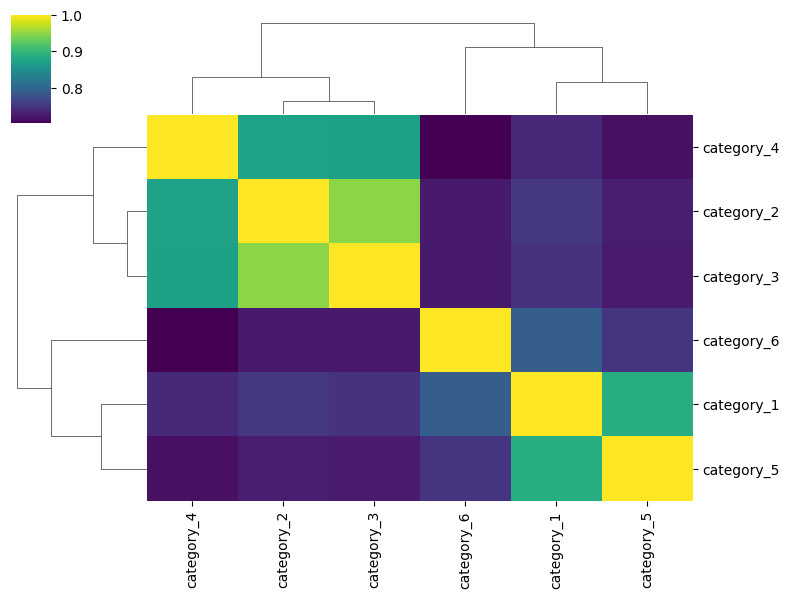

In [1122]:
import seaborn as sns
test=dfx.filter(like='category_')#.category.value_counts())

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

df_encoded = test.apply(LabelEncoder().fit_transform)
sns.clustermap(df_encoded.corr(), method='average', cmap='viridis', figsize=(8,6))

In [1126]:


df_filtered = dfx.filter(like="category_")
stability = df_filtered.apply(lambda col: col.value_counts(normalize=True).max(),axis=1).mean()
print(stability)



0.9209233791748527


In [1127]:
d(50)
dfx.head(3)

,name,category_1,explanation_1,original_index,name_2,category_2,explanation_2,country_1,field_1,name_3,...,category_6,explanation_6,path,folder,journal,labels,retraction_counts,text,category,difference_count
0,Nature1,Misconduct,The text describes the removal of a fossil fro...,Nature1,Nature1,Misconduct,The retraction of the paper was linked to cont...,Brazil,Earth Science,Nature1,...,Misconduct,The sentence suggests that the removal of the ...,Data_Nature\relevant_final\Nature1.pdf,Data_Nature\relevant_final,Nature,"[text, text, text, text, text, section_header,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]",Prized dinosaur fossil returnedto Brazil after...,Misconduct,0
1,Nature100,Misconduct,The text describes overt scientific misconduct...,Nature100,Nature100,Misconduct,The text describes overt scientific misconduct...,United State,Medicine and Health,Nature100,...,Misconduct,"The text details allegations of faked results,...",Data_Nature\relevant_final\Nature100.pdf,Data_Nature\relevant_final,Nature,"[section_header, section_header, text, text, t...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","Myocardialinfarction,commonlyknownas aheart at...",Misconduct,0
2,Nature1002,Mistake,The text discusses historical cases where erro...,Nature1002,Nature1002,Mistake,The text discusses historical errors and misun...,Germany,Chemistry,Nature1002,...,Mistake,The text discusses historical misunderstanding...,Data_Nature\relevant_final\Nature1002.pdf,Data_Nature\relevant_final,Nature,"[section_header, text, text, text, text, text,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","In another case,evidence amassed by the Marsha...",Mistake,0


In [1128]:
df_encoded
test.category_3.unique()

array(['Misconduct', 'Mistake', 'None'], dtype=object)

In [1129]:
dfx.to_csv('2025-06-08 full data with 6x GPT41.csv', index=False)
dfx.to_json('2025-06-08 full data with 6x GPT41.json', index=False)